In [1]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from zipfile import ZipFile

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [4]:
base_dir = 'catsdogs'
batch_size = 64
img_size = 64

training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=33,
  image_size=(img_size, img_size),
  batch_size=batch_size)

validation_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=33,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 12583 files belonging to 1 classes.
Using 10067 files for training.
Found 12583 files belonging to 1 classes.
Using 2516 files for validation.


['Cat']


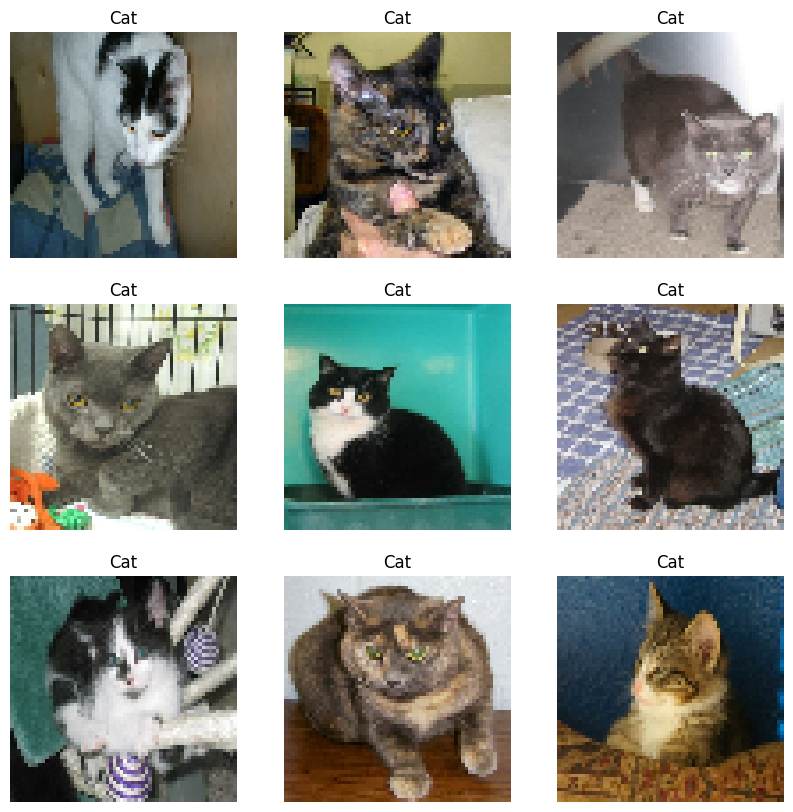

In [7]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show() 

In [8]:
def grayscale_norm(image, label):
    image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    return image, label

In [9]:
x_train = training_set.map(lambda image,label: ((grayscale_norm(image, label))))
x_test = validation_set.map(lambda image,label: ((grayscale_norm(image, label))))

['Cat']


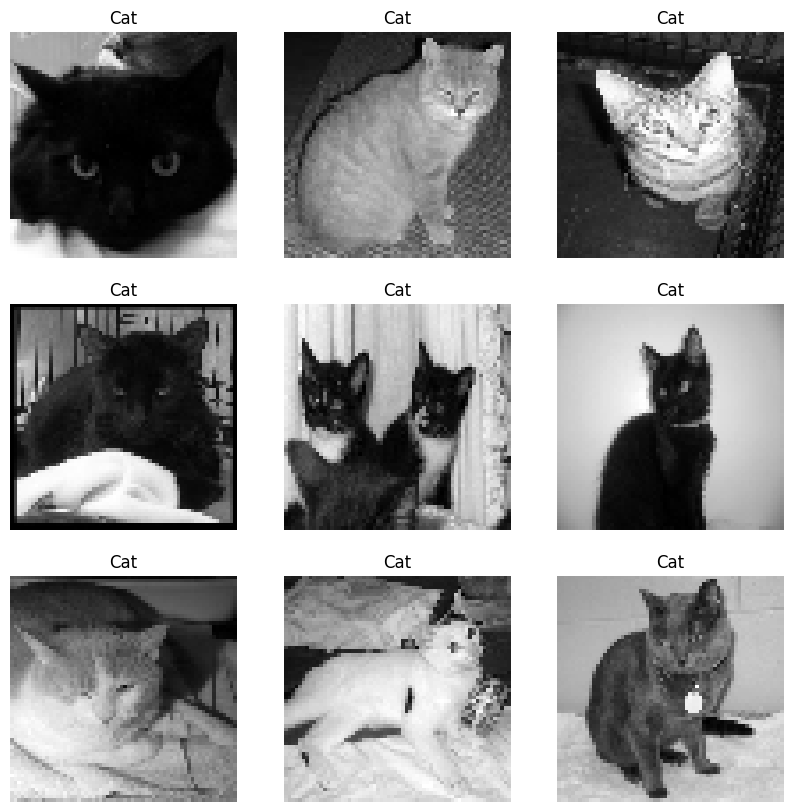

In [10]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, _ in x_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('float32'), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show() 

In [11]:
latent_dim = 1024
input_shape = (img_size, img_size, 1)
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [13]:
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [14]:
num_features = shape_before_flattening[1] * shape_before_flattening[2] * shape_before_flattening[3]

In [15]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [16]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 1024),            537209920 
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         268872065 
                                                                 
Total params: 806081985 (3.00 GB)
Trainable params: 806081985 (3.00 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [18]:
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

In [19]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=150, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/150
 24/158 [===>..........................] - ETA: 44s - loss: 239736.5156 - kl_loss: 167.7891 - reconstruction_loss: 239.5687

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 131516.9844 - kl_loss: 742.8896 - reconstruction_loss: 130.7741

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 6s - loss: 126212.6250 - kl_loss: 794.4653 - reconstruction_loss: 125.4182

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 5s - loss: 125118.6406 - kl_loss: 806.4211 - reconstruction_loss: 124.3122

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 119137.3828 - kl_loss: 859.8560 - reconstruction_loss: 118.2752

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 67s 366ms/step - loss: 119137.3828 - kl_loss: 859.8560 - reconstruction_loss: 118.2752 - val_loss: 71638.6406 - val_kl_loss: 1376.9235 - val_reconstruction_loss: 70.2610
Epoch 2/150
 24/158 [===>..........................] - ETA: 45s - loss: 67958.9141 - kl_loss: 1391.9644 - reconstruction_loss: 66.5669

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 58168.3359 - kl_loss: 1516.3539 - reconstruction_loss: 56.6520

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 6s - loss: 57353.4961 - kl_loss: 1530.8062 - reconstruction_loss: 55.8227

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 5s - loss: 57141.0820 - kl_loss: 1532.7174 - reconstruction_loss: 55.6084

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 56090.8867 - kl_loss: 1541.9022 - reconstruction_loss: 54.5483

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 58s 367ms/step - loss: 56090.8867 - kl_loss: 1541.9022 - reconstruction_loss: 54.5483 - val_loss: 49556.0547 - val_kl_loss: 1652.0591 - val_reconstruction_loss: 47.9040
Epoch 3/150
 24/158 [===>..........................] - ETA: 47s - loss: 48755.7383 - kl_loss: 1636.7223 - reconstruction_loss: 47.1190

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 43882.5586 - kl_loss: 1706.7678 - reconstruction_loss: 42.1758

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 43719.3281 - kl_loss: 1707.1433 - reconstruction_loss: 42.0122

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 43653.7266 - kl_loss: 1708.7867 - reconstruction_loss: 41.9449

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 43110.5742 - kl_loss: 1715.0945 - reconstruction_loss: 41.3956

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 61s 381ms/step - loss: 43110.5742 - kl_loss: 1715.0945 - reconstruction_loss: 41.3956 - val_loss: 41734.4570 - val_kl_loss: 1760.4750 - val_reconstruction_loss: 39.9755
Epoch 4/150
 24/158 [===>..........................] - ETA: 47s - loss: 39120.2305 - kl_loss: 1777.4735 - reconstruction_loss: 37.3428

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 37053.2305 - kl_loss: 1796.4718 - reconstruction_loss: 35.2567

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 36964.0977 - kl_loss: 1798.6179 - reconstruction_loss: 35.1655

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 36904.4883 - kl_loss: 1798.4838 - reconstruction_loss: 35.1060

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 36582.6914 - kl_loss: 1802.5714 - reconstruction_loss: 34.7800

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 36582.6914 - kl_loss: 1802.5714 - reconstruction_loss: 34.7800 - val_loss: 38135.4648 - val_kl_loss: 1818.4762 - val_reconstruction_loss: 36.3153
Epoch 5/150
 24/158 [===>..........................] - ETA: 48s - loss: 33882.9375 - kl_loss: 1848.7264 - reconstruction_loss: 32.0342

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 32281.1875 - kl_loss: 1857.2419 - reconstruction_loss: 30.4239

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 32244.3340 - kl_loss: 1857.8254 - reconstruction_loss: 30.3865

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 32206.9902 - kl_loss: 1858.5533 - reconstruction_loss: 30.3484

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 31999.8770 - kl_loss: 1860.5471 - reconstruction_loss: 30.1392

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 31999.8770 - kl_loss: 1860.5471 - reconstruction_loss: 30.1392 - val_loss: 35464.1328 - val_kl_loss: 1850.3555 - val_reconstruction_loss: 33.6143
Epoch 6/150
 24/158 [===>..........................] - ETA: 48s - loss: 29976.2500 - kl_loss: 1899.5160 - reconstruction_loss: 28.0767

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 28944.0000 - kl_loss: 1902.4906 - reconstruction_loss: 27.0415

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 28807.9824 - kl_loss: 1904.7686 - reconstruction_loss: 26.9032

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 28794.3164 - kl_loss: 1905.1713 - reconstruction_loss: 26.8891

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 28597.2246 - kl_loss: 1907.4318 - reconstruction_loss: 26.6898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 61s 381ms/step - loss: 28597.2246 - kl_loss: 1907.4318 - reconstruction_loss: 26.6898 - val_loss: 35814.6094 - val_kl_loss: 1899.3674 - val_reconstruction_loss: 33.9165
Epoch 7/150
 24/158 [===>..........................] - ETA: 48s - loss: 27836.2656 - kl_loss: 1917.1992 - reconstruction_loss: 25.9191

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 26140.0254 - kl_loss: 1932.6400 - reconstruction_loss: 24.2074

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 26188.7695 - kl_loss: 1932.0779 - reconstruction_loss: 24.2567

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 26151.4590 - kl_loss: 1932.4393 - reconstruction_loss: 24.2190

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 25881.3242 - kl_loss: 1934.8140 - reconstruction_loss: 23.9461

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 25881.3242 - kl_loss: 1934.8140 - reconstruction_loss: 23.9461 - val_loss: 34580.0117 - val_kl_loss: 1947.0809 - val_reconstruction_loss: 32.6338
Epoch 8/150
 24/158 [===>..........................] - ETA: 48s - loss: 24239.4238 - kl_loss: 1938.1293 - reconstruction_loss: 22.3013

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 22902.8223 - kl_loss: 1943.6530 - reconstruction_loss: 20.9592

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 22834.4102 - kl_loss: 1944.2007 - reconstruction_loss: 20.8902

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 22793.0703 - kl_loss: 1943.3912 - reconstruction_loss: 20.8497

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 22681.9590 - kl_loss: 1944.0542 - reconstruction_loss: 20.7376

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 22681.9590 - kl_loss: 1944.0542 - reconstruction_loss: 20.7376 - val_loss: 34556.7461 - val_kl_loss: 1947.1823 - val_reconstruction_loss: 32.6113
Epoch 9/150
 24/158 [===>..........................] - ETA: 48s - loss: 21317.2285 - kl_loss: 1941.7494 - reconstruction_loss: 19.3755

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 20384.9844 - kl_loss: 1945.3895 - reconstruction_loss: 18.4396

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 20366.4746 - kl_loss: 1945.0430 - reconstruction_loss: 18.4214

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 20339.7363 - kl_loss: 1945.0432 - reconstruction_loss: 18.3947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 20143.8828 - kl_loss: 1942.6060 - reconstruction_loss: 18.2018

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 20143.8828 - kl_loss: 1942.6060 - reconstruction_loss: 18.2018 - val_loss: 34210.0508 - val_kl_loss: 1925.7903 - val_reconstruction_loss: 32.2845
Epoch 10/150
 24/158 [===>..........................] - ETA: 48s - loss: 18766.4863 - kl_loss: 1930.4272 - reconstruction_loss: 16.8361

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 18403.0820 - kl_loss: 1939.3716 - reconstruction_loss: 16.4637

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 18288.5586 - kl_loss: 1940.3835 - reconstruction_loss: 16.3482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 18258.7949 - kl_loss: 1939.1533 - reconstruction_loss: 16.3196

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 18130.7949 - kl_loss: 1939.9031 - reconstruction_loss: 16.1910

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 18130.7949 - kl_loss: 1939.9031 - reconstruction_loss: 16.1910 - val_loss: 34032.0234 - val_kl_loss: 1913.0601 - val_reconstruction_loss: 32.1180
Epoch 11/150
 24/158 [===>..........................] - ETA: 48s - loss: 17126.8125 - kl_loss: 1933.4288 - reconstruction_loss: 15.1934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 16937.9863 - kl_loss: 1939.1448 - reconstruction_loss: 14.9988

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 16891.0059 - kl_loss: 1939.6526 - reconstruction_loss: 14.9514

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 16855.9062 - kl_loss: 1939.1603 - reconstruction_loss: 14.9167

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 16729.3516 - kl_loss: 1938.7776 - reconstruction_loss: 14.7903

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 381ms/step - loss: 16729.3516 - kl_loss: 1938.7776 - reconstruction_loss: 14.7903 - val_loss: 34122.6992 - val_kl_loss: 1912.2817 - val_reconstruction_loss: 32.2087
Epoch 12/150
 24/158 [===>..........................] - ETA: 48s - loss: 16062.3975 - kl_loss: 1938.9697 - reconstruction_loss: 14.1234

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 15497.5879 - kl_loss: 1935.7018 - reconstruction_loss: 13.5619

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 15480.8174 - kl_loss: 1937.5312 - reconstruction_loss: 13.5433

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 15461.2373 - kl_loss: 1937.8925 - reconstruction_loss: 13.5233

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 15411.5967 - kl_loss: 1936.1202 - reconstruction_loss: 13.4755

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 15411.5967 - kl_loss: 1936.1202 - reconstruction_loss: 13.4755 - val_loss: 34583.8359 - val_kl_loss: 1935.5526 - val_reconstruction_loss: 32.6481
Epoch 13/150
 24/158 [===>..........................] - ETA: 48s - loss: 14968.7139 - kl_loss: 1931.3644 - reconstruction_loss: 13.0373

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 14329.6787 - kl_loss: 1934.1823 - reconstruction_loss: 12.3955

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 14327.1436 - kl_loss: 1933.2762 - reconstruction_loss: 12.3939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 14323.9443 - kl_loss: 1933.6755 - reconstruction_loss: 12.3903

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 14259.3340 - kl_loss: 1931.7942 - reconstruction_loss: 12.3277

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 14259.3340 - kl_loss: 1931.7942 - reconstruction_loss: 12.3277 - val_loss: 34383.4453 - val_kl_loss: 1914.2214 - val_reconstruction_loss: 32.4696
Epoch 14/150
 24/158 [===>..........................] - ETA: 48s - loss: 14183.3994 - kl_loss: 1924.2778 - reconstruction_loss: 12.2591

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 13476.3760 - kl_loss: 1933.2188 - reconstruction_loss: 11.5432

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 13488.2129 - kl_loss: 1932.0032 - reconstruction_loss: 11.5562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 13500.0625 - kl_loss: 1931.6895 - reconstruction_loss: 11.5684

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 13456.2441 - kl_loss: 1930.9860 - reconstruction_loss: 11.5254

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 13456.2441 - kl_loss: 1930.9860 - reconstruction_loss: 11.5254 - val_loss: 34376.0977 - val_kl_loss: 1903.6667 - val_reconstruction_loss: 32.4721
Epoch 15/150
 24/158 [===>..........................] - ETA: 48s - loss: 13184.0625 - kl_loss: 1924.1758 - reconstruction_loss: 11.2599

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 12714.7656 - kl_loss: 1931.2604 - reconstruction_loss: 10.7835

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 12774.5137 - kl_loss: 1931.5122 - reconstruction_loss: 10.8430

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 12779.7402 - kl_loss: 1930.8353 - reconstruction_loss: 10.8489

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 12884.6885 - kl_loss: 1927.8376 - reconstruction_loss: 10.9568

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 12884.6885 - kl_loss: 1927.8376 - reconstruction_loss: 10.9568 - val_loss: 34570.4531 - val_kl_loss: 1934.3639 - val_reconstruction_loss: 32.6356
Epoch 16/150
 24/158 [===>..........................] - ETA: 47s - loss: 12851.7197 - kl_loss: 1945.8901 - reconstruction_loss: 10.9058

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 12403.0312 - kl_loss: 1936.4285 - reconstruction_loss: 10.4666

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 12365.2744 - kl_loss: 1935.6128 - reconstruction_loss: 10.4297

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 12378.9854 - kl_loss: 1935.6525 - reconstruction_loss: 10.4433

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 12333.0664 - kl_loss: 1932.3062 - reconstruction_loss: 10.4011

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 12333.0664 - kl_loss: 1932.3062 - reconstruction_loss: 10.4011 - val_loss: 34311.2227 - val_kl_loss: 1919.1482 - val_reconstruction_loss: 32.3915
Epoch 17/150
 24/158 [===>..........................] - ETA: 48s - loss: 11937.6182 - kl_loss: 1918.1831 - reconstruction_loss: 10.0194

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 11746.3740 - kl_loss: 1925.0029 - reconstruction_loss: 9.8214

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 11755.0996 - kl_loss: 1924.6968 - reconstruction_loss: 9.8304

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 11747.1904 - kl_loss: 1924.7196 - reconstruction_loss: 9.8225

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 11693.6689 - kl_loss: 1924.3350 - reconstruction_loss: 9.7695

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 11693.6689 - kl_loss: 1924.3350 - reconstruction_loss: 9.7695 - val_loss: 34199.8750 - val_kl_loss: 1913.1874 - val_reconstruction_loss: 32.2864
Epoch 18/150
 24/158 [===>..........................] - ETA: 48s - loss: 11346.8975 - kl_loss: 1924.0454 - reconstruction_loss: 9.4229

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 11238.6807 - kl_loss: 1926.7922 - reconstruction_loss: 9.3119

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 11235.0898 - kl_loss: 1926.5037 - reconstruction_loss: 9.3086

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 11237.0645 - kl_loss: 1926.6833 - reconstruction_loss: 9.3104

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 11190.7939 - kl_loss: 1924.3368 - reconstruction_loss: 9.2665

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 11190.7939 - kl_loss: 1924.3368 - reconstruction_loss: 9.2665 - val_loss: 34028.4922 - val_kl_loss: 1903.9323 - val_reconstruction_loss: 32.1246
Epoch 19/150
 24/158 [===>..........................] - ETA: 48s - loss: 10856.7158 - kl_loss: 1917.7496 - reconstruction_loss: 8.9390

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 10756.8193 - kl_loss: 1925.3221 - reconstruction_loss: 8.8315

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 10809.4395 - kl_loss: 1926.4531 - reconstruction_loss: 8.8830

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 10815.0850 - kl_loss: 1926.8152 - reconstruction_loss: 8.8883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 10802.2402 - kl_loss: 1925.0670 - reconstruction_loss: 8.8770

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 10802.2402 - kl_loss: 1925.0670 - reconstruction_loss: 8.8770 - val_loss: 34195.5273 - val_kl_loss: 1924.9094 - val_reconstruction_loss: 32.2695
Epoch 20/150
 24/158 [===>..........................] - ETA: 48s - loss: 10868.5010 - kl_loss: 1933.0831 - reconstruction_loss: 8.9354

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 10492.9629 - kl_loss: 1926.8455 - reconstruction_loss: 8.5661

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 10493.4268 - kl_loss: 1926.8885 - reconstruction_loss: 8.5665

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 10488.9307 - kl_loss: 1927.0326 - reconstruction_loss: 8.5619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 10479.7900 - kl_loss: 1924.5231 - reconstruction_loss: 8.5554

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 10479.7900 - kl_loss: 1924.5231 - reconstruction_loss: 8.5554 - val_loss: 34513.2422 - val_kl_loss: 1923.4104 - val_reconstruction_loss: 32.5892
Epoch 21/150
 24/158 [===>..........................] - ETA: 48s - loss: 10438.6064 - kl_loss: 1920.9596 - reconstruction_loss: 8.5176

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 10044.2998 - kl_loss: 1921.9120 - reconstruction_loss: 8.1224

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 10053.6191 - kl_loss: 1922.1041 - reconstruction_loss: 8.1315

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 10051.1387 - kl_loss: 1922.0187 - reconstruction_loss: 8.1291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 10005.5518 - kl_loss: 1919.7191 - reconstruction_loss: 8.0857

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 10005.5518 - kl_loss: 1919.7191 - reconstruction_loss: 8.0857 - val_loss: 34381.0469 - val_kl_loss: 1902.3982 - val_reconstruction_loss: 32.4790
Epoch 22/150
 24/158 [===>..........................] - ETA: 47s - loss: 10095.4736 - kl_loss: 1908.5913 - reconstruction_loss: 8.1869

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 9702.5098 - kl_loss: 1919.6067 - reconstruction_loss: 7.7829

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 9714.2969 - kl_loss: 1920.6968 - reconstruction_loss: 7.7936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 9704.4668 - kl_loss: 1920.1549 - reconstruction_loss: 7.7843

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 9660.2061 - kl_loss: 1918.4878 - reconstruction_loss: 7.7417

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 9660.2061 - kl_loss: 1918.4878 - reconstruction_loss: 7.7417 - val_loss: 34301.0703 - val_kl_loss: 1897.7152 - val_reconstruction_loss: 32.4038
Epoch 23/150
 24/158 [===>..........................] - ETA: 48s - loss: 9751.2402 - kl_loss: 1916.9552 - reconstruction_loss: 7.8343

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 9477.9678 - kl_loss: 1920.4493 - reconstruction_loss: 7.5575

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 9484.3438 - kl_loss: 1920.3215 - reconstruction_loss: 7.5640

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 9481.8115 - kl_loss: 1919.8025 - reconstruction_loss: 7.5620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 9458.6064 - kl_loss: 1918.7997 - reconstruction_loss: 7.5398

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 9458.6064 - kl_loss: 1918.7997 - reconstruction_loss: 7.5398 - val_loss: 34476.9219 - val_kl_loss: 1954.5107 - val_reconstruction_loss: 32.5225
Epoch 24/150
 24/158 [===>..........................] - ETA: 47s - loss: 9131.0879 - kl_loss: 1913.8271 - reconstruction_loss: 7.2173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 9209.1826 - kl_loss: 1916.6124 - reconstruction_loss: 7.2926

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 9199.0068 - kl_loss: 1917.1807 - reconstruction_loss: 7.2818

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 9185.1445 - kl_loss: 1916.6587 - reconstruction_loss: 7.2685

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 9164.5244 - kl_loss: 1916.0173 - reconstruction_loss: 7.2485

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 9164.5244 - kl_loss: 1916.0173 - reconstruction_loss: 7.2485 - val_loss: 34056.9258 - val_kl_loss: 1867.5457 - val_reconstruction_loss: 32.1890
Epoch 25/150
 24/158 [===>..........................] - ETA: 47s - loss: 9080.5957 - kl_loss: 1908.1510 - reconstruction_loss: 7.1724

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 8984.4541 - kl_loss: 1917.4727 - reconstruction_loss: 7.0670

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 8972.1250 - kl_loss: 1918.2222 - reconstruction_loss: 7.0539

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 8971.6729 - kl_loss: 1918.6951 - reconstruction_loss: 7.0530

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 8945.2227 - kl_loss: 1915.5673 - reconstruction_loss: 7.0294

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 8945.2227 - kl_loss: 1915.5673 - reconstruction_loss: 7.0294 - val_loss: 34343.7539 - val_kl_loss: 1931.1073 - val_reconstruction_loss: 32.4126
Epoch 26/150
 24/158 [===>..........................] - ETA: 47s - loss: 8816.8936 - kl_loss: 1908.6670 - reconstruction_loss: 6.9082

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 8646.1357 - kl_loss: 1914.3215 - reconstruction_loss: 6.7318

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 8641.6689 - kl_loss: 1914.2871 - reconstruction_loss: 6.7274

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 8645.3770 - kl_loss: 1914.3783 - reconstruction_loss: 6.7310

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 8644.3701 - kl_loss: 1913.6831 - reconstruction_loss: 6.7305

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 8644.3701 - kl_loss: 1913.6831 - reconstruction_loss: 6.7305 - val_loss: 34829.6367 - val_kl_loss: 1834.7589 - val_reconstruction_loss: 32.9945
Epoch 27/150
 24/158 [===>..........................] - ETA: 47s - loss: 8729.8486 - kl_loss: 1914.8931 - reconstruction_loss: 6.8150

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 8458.4385 - kl_loss: 1914.9755 - reconstruction_loss: 6.5435

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 8452.0566 - kl_loss: 1915.5336 - reconstruction_loss: 6.5365

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 8453.3398 - kl_loss: 1915.5432 - reconstruction_loss: 6.5378

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 8443.0107 - kl_loss: 1913.7170 - reconstruction_loss: 6.5293

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 8443.0107 - kl_loss: 1913.7170 - reconstruction_loss: 6.5293 - val_loss: 34453.4961 - val_kl_loss: 1886.1437 - val_reconstruction_loss: 32.5671
Epoch 28/150
 24/158 [===>..........................] - ETA: 47s - loss: 8524.1650 - kl_loss: 1903.7626 - reconstruction_loss: 6.6204

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 8334.7676 - kl_loss: 1914.3385 - reconstruction_loss: 6.4204

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 8344.5029 - kl_loss: 1915.7219 - reconstruction_loss: 6.4288

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 8351.0234 - kl_loss: 1915.3253 - reconstruction_loss: 6.4357

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 8328.0898 - kl_loss: 1914.0034 - reconstruction_loss: 6.4143

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 8328.0898 - kl_loss: 1914.0034 - reconstruction_loss: 6.4143 - val_loss: 34181.6953 - val_kl_loss: 1925.7731 - val_reconstruction_loss: 32.2557
Epoch 29/150
 24/158 [===>..........................] - ETA: 47s - loss: 8124.1284 - kl_loss: 1906.5210 - reconstruction_loss: 6.2176

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 8117.4355 - kl_loss: 1909.2802 - reconstruction_loss: 6.2082

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 8121.1929 - kl_loss: 1909.9148 - reconstruction_loss: 6.2113

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 8129.2617 - kl_loss: 1909.9843 - reconstruction_loss: 6.2193

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 8152.5918 - kl_loss: 1909.3597 - reconstruction_loss: 6.2433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 8152.5918 - kl_loss: 1909.3597 - reconstruction_loss: 6.2433 - val_loss: 34006.8164 - val_kl_loss: 1879.5088 - val_reconstruction_loss: 32.1271
Epoch 30/150
 24/158 [===>..........................] - ETA: 48s - loss: 8174.7480 - kl_loss: 1909.5148 - reconstruction_loss: 6.2652

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 7906.2402 - kl_loss: 1909.6473 - reconstruction_loss: 5.9966

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 7905.8135 - kl_loss: 1910.0914 - reconstruction_loss: 5.9957

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 7899.7241 - kl_loss: 1910.2975 - reconstruction_loss: 5.9894

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 7876.8188 - kl_loss: 1909.0438 - reconstruction_loss: 5.9676

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 7876.8188 - kl_loss: 1909.0438 - reconstruction_loss: 5.9676 - val_loss: 33791.2656 - val_kl_loss: 1876.6554 - val_reconstruction_loss: 31.9145
Epoch 31/150
 24/158 [===>..........................] - ETA: 48s - loss: 8079.1050 - kl_loss: 1900.5005 - reconstruction_loss: 6.1786

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 8081.5210 - kl_loss: 1914.3539 - reconstruction_loss: 6.1672

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 8052.3252 - kl_loss: 1914.1510 - reconstruction_loss: 6.1382

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 8043.8057 - kl_loss: 1913.9995 - reconstruction_loss: 6.1298

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 7998.9897 - kl_loss: 1912.2168 - reconstruction_loss: 6.0869

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 7998.9897 - kl_loss: 1912.2168 - reconstruction_loss: 6.0869 - val_loss: 34203.1836 - val_kl_loss: 1924.1355 - val_reconstruction_loss: 32.2787
Epoch 32/150
 24/158 [===>..........................] - ETA: 47s - loss: 7690.1157 - kl_loss: 1902.2448 - reconstruction_loss: 5.7879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 7711.7231 - kl_loss: 1908.0782 - reconstruction_loss: 5.8036

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 7685.0405 - kl_loss: 1908.9952 - reconstruction_loss: 5.7760

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 7680.4937 - kl_loss: 1908.8231 - reconstruction_loss: 5.7717

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 7668.4121 - kl_loss: 1907.3301 - reconstruction_loss: 5.7609

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 7668.4121 - kl_loss: 1907.3301 - reconstruction_loss: 5.7609 - val_loss: 34199.6016 - val_kl_loss: 1916.5472 - val_reconstruction_loss: 32.2824
Epoch 33/150
 24/158 [===>..........................] - ETA: 48s - loss: 7406.8472 - kl_loss: 1900.0156 - reconstruction_loss: 5.5068

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 7351.7158 - kl_loss: 1900.9323 - reconstruction_loss: 5.4508

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 7351.6021 - kl_loss: 1901.0082 - reconstruction_loss: 5.4506

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 7344.7236 - kl_loss: 1900.8070 - reconstruction_loss: 5.4439

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 7342.6401 - kl_loss: 1900.7941 - reconstruction_loss: 5.4421

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 7342.6401 - kl_loss: 1900.7941 - reconstruction_loss: 5.4421 - val_loss: 34055.1211 - val_kl_loss: 1881.0415 - val_reconstruction_loss: 32.1736
Epoch 34/150
 24/158 [===>..........................] - ETA: 47s - loss: 7195.2056 - kl_loss: 1897.0934 - reconstruction_loss: 5.2981

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 7181.1313 - kl_loss: 1900.1222 - reconstruction_loss: 5.2810

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 7189.5210 - kl_loss: 1901.5804 - reconstruction_loss: 5.2879

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 7188.6812 - kl_loss: 1901.6600 - reconstruction_loss: 5.2870

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 7167.4849 - kl_loss: 1900.1279 - reconstruction_loss: 5.2674

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 7167.4849 - kl_loss: 1900.1279 - reconstruction_loss: 5.2674 - val_loss: 33818.2266 - val_kl_loss: 1910.7700 - val_reconstruction_loss: 31.9076
Epoch 35/150
 24/158 [===>..........................] - ETA: 47s - loss: 7182.9419 - kl_loss: 1902.5878 - reconstruction_loss: 5.2804

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 7076.8652 - kl_loss: 1903.2207 - reconstruction_loss: 5.1736

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 7084.9272 - kl_loss: 1903.8138 - reconstruction_loss: 5.1811

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 7087.1826 - kl_loss: 1903.6372 - reconstruction_loss: 5.1835

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 7060.9897 - kl_loss: 1902.8169 - reconstruction_loss: 5.1580

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 7060.9897 - kl_loss: 1902.8169 - reconstruction_loss: 5.1580 - val_loss: 33816.7383 - val_kl_loss: 1899.6339 - val_reconstruction_loss: 31.9174
Epoch 36/150
 24/158 [===>..........................] - ETA: 47s - loss: 6995.9253 - kl_loss: 1896.2709 - reconstruction_loss: 5.0997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6877.2046 - kl_loss: 1897.3812 - reconstruction_loss: 4.9798

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6891.6909 - kl_loss: 1898.0769 - reconstruction_loss: 4.9936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6892.6279 - kl_loss: 1898.4623 - reconstruction_loss: 4.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6882.8511 - kl_loss: 1897.6201 - reconstruction_loss: 4.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 6882.8511 - kl_loss: 1897.6201 - reconstruction_loss: 4.9856 - val_loss: 34033.8750 - val_kl_loss: 1859.2086 - val_reconstruction_loss: 32.1751
Epoch 37/150
 24/158 [===>..........................] - ETA: 47s - loss: 6849.9800 - kl_loss: 1895.2098 - reconstruction_loss: 4.9548

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6833.6396 - kl_loss: 1898.7552 - reconstruction_loss: 4.9349

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6859.2417 - kl_loss: 1899.2498 - reconstruction_loss: 4.9600

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6862.9463 - kl_loss: 1899.6421 - reconstruction_loss: 4.9633

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6891.6406 - kl_loss: 1898.4980 - reconstruction_loss: 4.9932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 6891.6406 - kl_loss: 1898.4980 - reconstruction_loss: 4.9932 - val_loss: 34373.1680 - val_kl_loss: 1902.0250 - val_reconstruction_loss: 32.4714
Epoch 38/150
 24/158 [===>..........................] - ETA: 47s - loss: 7124.6289 - kl_loss: 1901.5548 - reconstruction_loss: 5.2231

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6916.9277 - kl_loss: 1900.9076 - reconstruction_loss: 5.0160

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6909.9531 - kl_loss: 1900.2119 - reconstruction_loss: 5.0097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6908.1372 - kl_loss: 1900.1899 - reconstruction_loss: 5.0080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6901.5942 - kl_loss: 1898.5864 - reconstruction_loss: 5.0031

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 6901.5942 - kl_loss: 1898.5864 - reconstruction_loss: 5.0031 - val_loss: 34530.7422 - val_kl_loss: 1880.9373 - val_reconstruction_loss: 32.6501
Epoch 39/150
 24/158 [===>..........................] - ETA: 47s - loss: 7032.8965 - kl_loss: 1894.6198 - reconstruction_loss: 5.1383

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6755.5596 - kl_loss: 1895.7380 - reconstruction_loss: 4.8598

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6756.2891 - kl_loss: 1895.6625 - reconstruction_loss: 4.8606

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6761.1221 - kl_loss: 1895.7633 - reconstruction_loss: 4.8654

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6747.6172 - kl_loss: 1894.7257 - reconstruction_loss: 4.8532

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 6747.6172 - kl_loss: 1894.7257 - reconstruction_loss: 4.8532 - val_loss: 33669.2539 - val_kl_loss: 1851.2770 - val_reconstruction_loss: 31.8176
Epoch 40/150
 24/158 [===>..........................] - ETA: 48s - loss: 6658.2417 - kl_loss: 1886.4366 - reconstruction_loss: 4.7718

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6477.3867 - kl_loss: 1891.2108 - reconstruction_loss: 4.5862

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6477.9194 - kl_loss: 1891.8002 - reconstruction_loss: 4.5861

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6479.2012 - kl_loss: 1891.9380 - reconstruction_loss: 4.5873

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6481.2549 - kl_loss: 1890.3856 - reconstruction_loss: 4.5908

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 6481.2549 - kl_loss: 1890.3856 - reconstruction_loss: 4.5908 - val_loss: 34293.2500 - val_kl_loss: 1904.1848 - val_reconstruction_loss: 32.3900
Epoch 41/150
 24/158 [===>..........................] - ETA: 47s - loss: 6453.4800 - kl_loss: 1887.6613 - reconstruction_loss: 4.5658

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6351.8901 - kl_loss: 1892.0698 - reconstruction_loss: 4.4598

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6353.4087 - kl_loss: 1892.8298 - reconstruction_loss: 4.4606

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6353.7163 - kl_loss: 1892.7185 - reconstruction_loss: 4.4610

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6369.9707 - kl_loss: 1891.0837 - reconstruction_loss: 4.4789

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 6369.9707 - kl_loss: 1891.0837 - reconstruction_loss: 4.4789 - val_loss: 33904.6523 - val_kl_loss: 1866.2455 - val_reconstruction_loss: 32.0394
Epoch 42/150
 24/158 [===>..........................] - ETA: 47s - loss: 6368.0586 - kl_loss: 1885.2885 - reconstruction_loss: 4.4828

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6309.0996 - kl_loss: 1889.6093 - reconstruction_loss: 4.4195

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6308.3389 - kl_loss: 1889.5564 - reconstruction_loss: 4.4188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6304.6899 - kl_loss: 1889.8340 - reconstruction_loss: 4.4149

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6292.5850 - kl_loss: 1887.9465 - reconstruction_loss: 4.4049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 6292.5850 - kl_loss: 1887.9465 - reconstruction_loss: 4.4049 - val_loss: 34152.1094 - val_kl_loss: 1874.5968 - val_reconstruction_loss: 32.2769
Epoch 43/150
 24/158 [===>..........................] - ETA: 47s - loss: 6302.5371 - kl_loss: 1887.4027 - reconstruction_loss: 4.4151

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6298.6460 - kl_loss: 1889.4174 - reconstruction_loss: 4.4092

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6293.0591 - kl_loss: 1889.9019 - reconstruction_loss: 4.4032

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6293.8418 - kl_loss: 1890.3464 - reconstruction_loss: 4.4035

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6273.5552 - kl_loss: 1888.9875 - reconstruction_loss: 4.3848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 61s 382ms/step - loss: 6273.5552 - kl_loss: 1888.9875 - reconstruction_loss: 4.3848 - val_loss: 33807.4219 - val_kl_loss: 1872.3170 - val_reconstruction_loss: 31.9354
Epoch 44/150
 24/158 [===>..........................] - ETA: 47s - loss: 6148.0874 - kl_loss: 1876.9620 - reconstruction_loss: 4.2711

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 6095.9834 - kl_loss: 1883.1730 - reconstruction_loss: 4.2128

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 6087.3467 - kl_loss: 1883.4244 - reconstruction_loss: 4.2039

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 6085.3896 - kl_loss: 1883.5771 - reconstruction_loss: 4.2018

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 6065.3838 - kl_loss: 1882.5817 - reconstruction_loss: 4.1826

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 6065.3838 - kl_loss: 1882.5817 - reconstruction_loss: 4.1826 - val_loss: 33728.1328 - val_kl_loss: 1858.8899 - val_reconstruction_loss: 31.8684
Epoch 45/150
 24/158 [===>..........................] - ETA: 48s - loss: 5948.9751 - kl_loss: 1873.8438 - reconstruction_loss: 4.0751

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5933.5151 - kl_loss: 1881.1439 - reconstruction_loss: 4.0524

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5941.8672 - kl_loss: 1881.0935 - reconstruction_loss: 4.0608

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5943.5513 - kl_loss: 1881.5938 - reconstruction_loss: 4.0620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5937.6602 - kl_loss: 1880.3289 - reconstruction_loss: 4.0573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5937.6602 - kl_loss: 1880.3289 - reconstruction_loss: 4.0573 - val_loss: 33206.0352 - val_kl_loss: 1820.3630 - val_reconstruction_loss: 31.3853
Epoch 46/150
 24/158 [===>..........................] - ETA: 47s - loss: 6179.0918 - kl_loss: 1882.9810 - reconstruction_loss: 4.2961

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5984.8013 - kl_loss: 1884.6769 - reconstruction_loss: 4.1001

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5986.9712 - kl_loss: 1885.6409 - reconstruction_loss: 4.1013

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5982.8999 - kl_loss: 1885.3826 - reconstruction_loss: 4.0975

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5964.8047 - kl_loss: 1883.6742 - reconstruction_loss: 4.0813

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 380ms/step - loss: 5964.8047 - kl_loss: 1883.6742 - reconstruction_loss: 4.0813 - val_loss: 34174.3672 - val_kl_loss: 1872.0018 - val_reconstruction_loss: 32.3025
Epoch 47/150
 24/158 [===>..........................] - ETA: 47s - loss: 6196.3770 - kl_loss: 1876.6276 - reconstruction_loss: 4.3197

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5939.8389 - kl_loss: 1883.9363 - reconstruction_loss: 4.0559

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5931.2783 - kl_loss: 1883.0887 - reconstruction_loss: 4.0482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5928.8677 - kl_loss: 1883.3788 - reconstruction_loss: 4.0455

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5898.4424 - kl_loss: 1881.2028 - reconstruction_loss: 4.0174

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5898.4424 - kl_loss: 1881.2028 - reconstruction_loss: 4.0174 - val_loss: 33847.9883 - val_kl_loss: 1862.3788 - val_reconstruction_loss: 31.9860
Epoch 48/150
 24/158 [===>..........................] - ETA: 47s - loss: 5837.4780 - kl_loss: 1866.5238 - reconstruction_loss: 3.9710

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5811.7979 - kl_loss: 1876.1296 - reconstruction_loss: 3.9357

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5819.6602 - kl_loss: 1876.6036 - reconstruction_loss: 3.9431

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5820.4736 - kl_loss: 1877.0312 - reconstruction_loss: 3.9434

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5820.7798 - kl_loss: 1876.6866 - reconstruction_loss: 3.9440

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5820.7798 - kl_loss: 1876.6866 - reconstruction_loss: 3.9440 - val_loss: 34261.1797 - val_kl_loss: 1865.7649 - val_reconstruction_loss: 32.3961
Epoch 49/150
 24/158 [===>..........................] - ETA: 47s - loss: 6003.3071 - kl_loss: 1876.4586 - reconstruction_loss: 4.1268

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5755.3999 - kl_loss: 1876.1865 - reconstruction_loss: 3.8792

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5764.2139 - kl_loss: 1877.6233 - reconstruction_loss: 3.8866

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5764.2329 - kl_loss: 1877.3783 - reconstruction_loss: 3.8869

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5803.8647 - kl_loss: 1876.6906 - reconstruction_loss: 3.9269

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 5803.8647 - kl_loss: 1876.6906 - reconstruction_loss: 3.9269 - val_loss: 34505.7344 - val_kl_loss: 1819.3762 - val_reconstruction_loss: 32.6861
Epoch 50/150
 24/158 [===>..........................] - ETA: 47s - loss: 5942.9565 - kl_loss: 1879.0453 - reconstruction_loss: 4.0639

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5813.4058 - kl_loss: 1880.7968 - reconstruction_loss: 3.9326

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5803.8301 - kl_loss: 1881.6145 - reconstruction_loss: 3.9222

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5802.3286 - kl_loss: 1881.4027 - reconstruction_loss: 3.9209

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5802.7871 - kl_loss: 1879.7682 - reconstruction_loss: 3.9231

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5802.7871 - kl_loss: 1879.7682 - reconstruction_loss: 3.9231 - val_loss: 33837.6445 - val_kl_loss: 1881.8466 - val_reconstruction_loss: 31.9565
Epoch 51/150
 24/158 [===>..........................] - ETA: 47s - loss: 5651.8477 - kl_loss: 1864.7485 - reconstruction_loss: 3.7871

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5710.7554 - kl_loss: 1873.8251 - reconstruction_loss: 3.8369

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5700.4233 - kl_loss: 1874.7164 - reconstruction_loss: 3.8257

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5696.6221 - kl_loss: 1874.6285 - reconstruction_loss: 3.8220

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5676.3750 - kl_loss: 1873.6116 - reconstruction_loss: 3.8028

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5676.3750 - kl_loss: 1873.6116 - reconstruction_loss: 3.8028 - val_loss: 33544.9375 - val_kl_loss: 1882.6653 - val_reconstruction_loss: 31.6622
Epoch 52/150
 24/158 [===>..........................] - ETA: 47s - loss: 5514.9976 - kl_loss: 1866.7260 - reconstruction_loss: 3.6483

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5534.3320 - kl_loss: 1870.9093 - reconstruction_loss: 3.6634

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5546.4507 - kl_loss: 1871.2178 - reconstruction_loss: 3.6752

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5547.0649 - kl_loss: 1871.5126 - reconstruction_loss: 3.6756

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5536.1641 - kl_loss: 1870.4100 - reconstruction_loss: 3.6658

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5536.1641 - kl_loss: 1870.4100 - reconstruction_loss: 3.6658 - val_loss: 33703.5156 - val_kl_loss: 1858.2949 - val_reconstruction_loss: 31.8448
Epoch 53/150
 24/158 [===>..........................] - ETA: 47s - loss: 5468.1855 - kl_loss: 1860.9409 - reconstruction_loss: 3.6072

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5403.0166 - kl_loss: 1866.7672 - reconstruction_loss: 3.5362

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5407.9536 - kl_loss: 1867.5642 - reconstruction_loss: 3.5404

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5410.0229 - kl_loss: 1867.4211 - reconstruction_loss: 3.5426

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5399.6392 - kl_loss: 1866.8082 - reconstruction_loss: 3.5330

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5399.6392 - kl_loss: 1866.8082 - reconstruction_loss: 3.5330 - val_loss: 34607.6484 - val_kl_loss: 1860.4307 - val_reconstruction_loss: 32.7471
Epoch 54/150
 24/158 [===>..........................] - ETA: 47s - loss: 5507.6035 - kl_loss: 1866.2594 - reconstruction_loss: 3.6413

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5406.8325 - kl_loss: 1872.1697 - reconstruction_loss: 3.5347

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5403.8823 - kl_loss: 1872.2206 - reconstruction_loss: 3.5317

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5401.6562 - kl_loss: 1872.2354 - reconstruction_loss: 3.5294

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5390.4014 - kl_loss: 1869.7739 - reconstruction_loss: 3.5208

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5390.4014 - kl_loss: 1869.7739 - reconstruction_loss: 3.5208 - val_loss: 33666.2852 - val_kl_loss: 1878.8142 - val_reconstruction_loss: 31.7878
Epoch 55/150
 24/158 [===>..........................] - ETA: 47s - loss: 5402.5190 - kl_loss: 1861.4609 - reconstruction_loss: 3.5411

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5315.8540 - kl_loss: 1864.9895 - reconstruction_loss: 3.4509

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5332.9932 - kl_loss: 1866.6979 - reconstruction_loss: 3.4663

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5340.8340 - kl_loss: 1866.3120 - reconstruction_loss: 3.4745

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5388.2852 - kl_loss: 1866.5408 - reconstruction_loss: 3.5217

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5388.2852 - kl_loss: 1866.5408 - reconstruction_loss: 3.5217 - val_loss: 35544.4414 - val_kl_loss: 1896.1696 - val_reconstruction_loss: 33.6487
Epoch 56/150
 24/158 [===>..........................] - ETA: 48s - loss: 5778.5522 - kl_loss: 1875.6578 - reconstruction_loss: 3.9029

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5360.5029 - kl_loss: 1868.7695 - reconstruction_loss: 3.4917

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5359.6611 - kl_loss: 1868.2144 - reconstruction_loss: 3.4914

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5358.3325 - kl_loss: 1868.0175 - reconstruction_loss: 3.4903

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5351.0679 - kl_loss: 1866.1459 - reconstruction_loss: 3.4851

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5351.0679 - kl_loss: 1866.1459 - reconstruction_loss: 3.4851 - val_loss: 33672.3945 - val_kl_loss: 1861.4766 - val_reconstruction_loss: 31.8105
Epoch 57/150
 24/158 [===>..........................] - ETA: 47s - loss: 6045.6587 - kl_loss: 1863.5775 - reconstruction_loss: 4.1821

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5490.6187 - kl_loss: 1870.5323 - reconstruction_loss: 3.6201

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5471.8223 - kl_loss: 1870.8392 - reconstruction_loss: 3.6010

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5464.3994 - kl_loss: 1870.6815 - reconstruction_loss: 3.5937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5419.8096 - kl_loss: 1868.3890 - reconstruction_loss: 3.5516

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 379ms/step - loss: 5419.8096 - kl_loss: 1868.3890 - reconstruction_loss: 3.5516 - val_loss: 33345.7539 - val_kl_loss: 1850.4070 - val_reconstruction_loss: 31.4957
Epoch 58/150
 24/158 [===>..........................] - ETA: 47s - loss: 5352.7896 - kl_loss: 1850.3521 - reconstruction_loss: 3.5024

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5217.7930 - kl_loss: 1860.5435 - reconstruction_loss: 3.3572

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5200.9048 - kl_loss: 1861.3810 - reconstruction_loss: 3.3395

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5202.9683 - kl_loss: 1861.1168 - reconstruction_loss: 3.3419

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5176.5054 - kl_loss: 1859.6146 - reconstruction_loss: 3.3167

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5176.5054 - kl_loss: 1859.6146 - reconstruction_loss: 3.3167 - val_loss: 33293.8047 - val_kl_loss: 1851.3474 - val_reconstruction_loss: 31.4421
Epoch 59/150
 24/158 [===>..........................] - ETA: 48s - loss: 5023.2661 - kl_loss: 1843.8695 - reconstruction_loss: 3.1794

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5008.1665 - kl_loss: 1854.8762 - reconstruction_loss: 3.1533

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5000.3022 - kl_loss: 1855.1868 - reconstruction_loss: 3.1451

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4999.2500 - kl_loss: 1855.3597 - reconstruction_loss: 3.1439

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4998.2690 - kl_loss: 1855.0667 - reconstruction_loss: 3.1434

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4998.2690 - kl_loss: 1855.0667 - reconstruction_loss: 3.1434 - val_loss: 33446.7266 - val_kl_loss: 1837.8759 - val_reconstruction_loss: 31.6089
Epoch 60/150
 24/158 [===>..........................] - ETA: 47s - loss: 4974.3125 - kl_loss: 1851.5308 - reconstruction_loss: 3.1228

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5178.5591 - kl_loss: 1861.3735 - reconstruction_loss: 3.3172

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5171.2446 - kl_loss: 1862.2977 - reconstruction_loss: 3.3089

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5168.3008 - kl_loss: 1862.5079 - reconstruction_loss: 3.3058

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5145.4888 - kl_loss: 1861.4083 - reconstruction_loss: 3.2843

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5145.4888 - kl_loss: 1861.4083 - reconstruction_loss: 3.2843 - val_loss: 33833.0703 - val_kl_loss: 1832.5457 - val_reconstruction_loss: 32.0003
Epoch 61/150
 24/158 [===>..........................] - ETA: 47s - loss: 4971.5747 - kl_loss: 1849.9603 - reconstruction_loss: 3.1216

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 5064.1855 - kl_loss: 1855.1642 - reconstruction_loss: 3.2090

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 5064.9204 - kl_loss: 1856.1964 - reconstruction_loss: 3.2087

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 5062.9370 - kl_loss: 1855.6882 - reconstruction_loss: 3.2072

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 5047.3047 - kl_loss: 1855.6935 - reconstruction_loss: 3.1919

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 5047.3047 - kl_loss: 1855.6935 - reconstruction_loss: 3.1919 - val_loss: 33867.3984 - val_kl_loss: 1824.4956 - val_reconstruction_loss: 32.0428
Epoch 62/150
 24/158 [===>..........................] - ETA: 47s - loss: 4914.6704 - kl_loss: 1847.8975 - reconstruction_loss: 3.0668

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4938.7456 - kl_loss: 1852.4381 - reconstruction_loss: 3.0863

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4942.2998 - kl_loss: 1852.4979 - reconstruction_loss: 3.0898

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4943.1562 - kl_loss: 1852.7231 - reconstruction_loss: 3.0904

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4941.6855 - kl_loss: 1851.4785 - reconstruction_loss: 3.0902

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4941.6855 - kl_loss: 1851.4785 - reconstruction_loss: 3.0902 - val_loss: 33495.9375 - val_kl_loss: 1821.7817 - val_reconstruction_loss: 31.6739
Epoch 63/150
 24/158 [===>..........................] - ETA: 47s - loss: 4840.6948 - kl_loss: 1848.7032 - reconstruction_loss: 2.9920

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4854.1904 - kl_loss: 1850.7642 - reconstruction_loss: 3.0034

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4857.4219 - kl_loss: 1851.9117 - reconstruction_loss: 3.0055

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4856.4531 - kl_loss: 1851.8539 - reconstruction_loss: 3.0046

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4852.6328 - kl_loss: 1851.0679 - reconstruction_loss: 3.0017

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4852.6328 - kl_loss: 1851.0679 - reconstruction_loss: 3.0017 - val_loss: 33324.9414 - val_kl_loss: 1788.3042 - val_reconstruction_loss: 31.5369
Epoch 64/150
 24/158 [===>..........................] - ETA: 47s - loss: 4758.7358 - kl_loss: 1837.8947 - reconstruction_loss: 2.9208

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4805.0210 - kl_loss: 1848.2960 - reconstruction_loss: 2.9567

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4848.9165 - kl_loss: 1849.0969 - reconstruction_loss: 2.9998

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4855.9678 - kl_loss: 1849.8423 - reconstruction_loss: 3.0061

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4912.9429 - kl_loss: 1850.1779 - reconstruction_loss: 3.0627

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4912.9429 - kl_loss: 1850.1779 - reconstruction_loss: 3.0627 - val_loss: 34263.8203 - val_kl_loss: 1868.7035 - val_reconstruction_loss: 32.3954
Epoch 65/150
 24/158 [===>..........................] - ETA: 47s - loss: 5061.8213 - kl_loss: 1855.8297 - reconstruction_loss: 3.2060

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4883.4517 - kl_loss: 1852.1671 - reconstruction_loss: 3.0313

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4899.7603 - kl_loss: 1852.5376 - reconstruction_loss: 3.0472

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4899.2227 - kl_loss: 1852.5945 - reconstruction_loss: 3.0466

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4893.9727 - kl_loss: 1850.4331 - reconstruction_loss: 3.0437

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4893.9727 - kl_loss: 1850.4331 - reconstruction_loss: 3.0437 - val_loss: 33159.3359 - val_kl_loss: 1813.1753 - val_reconstruction_loss: 31.3462
Epoch 66/150
 24/158 [===>..........................] - ETA: 47s - loss: 4870.5444 - kl_loss: 1841.4733 - reconstruction_loss: 3.0291

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4775.0405 - kl_loss: 1846.9430 - reconstruction_loss: 2.9281

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4774.9702 - kl_loss: 1847.0084 - reconstruction_loss: 2.9280

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4772.4590 - kl_loss: 1847.0859 - reconstruction_loss: 2.9254

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4760.8857 - kl_loss: 1845.6340 - reconstruction_loss: 2.9152

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4760.8857 - kl_loss: 1845.6340 - reconstruction_loss: 2.9152 - val_loss: 33307.3945 - val_kl_loss: 1852.8364 - val_reconstruction_loss: 31.4543
Epoch 67/150
 24/158 [===>..........................] - ETA: 47s - loss: 4739.2031 - kl_loss: 1839.6823 - reconstruction_loss: 2.8995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4740.6709 - kl_loss: 1846.6876 - reconstruction_loss: 2.8940

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4737.5972 - kl_loss: 1846.9742 - reconstruction_loss: 2.8906

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4734.0776 - kl_loss: 1846.8269 - reconstruction_loss: 2.8873

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4722.8750 - kl_loss: 1844.4663 - reconstruction_loss: 2.8787

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4722.8750 - kl_loss: 1844.4663 - reconstruction_loss: 2.8787 - val_loss: 32989.8086 - val_kl_loss: 1814.3779 - val_reconstruction_loss: 31.1755
Epoch 68/150
 24/158 [===>..........................] - ETA: 47s - loss: 4780.2515 - kl_loss: 1836.4691 - reconstruction_loss: 2.9438

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4695.8975 - kl_loss: 1844.2875 - reconstruction_loss: 2.8516

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4700.1626 - kl_loss: 1844.7683 - reconstruction_loss: 2.8554

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4698.0835 - kl_loss: 1844.6055 - reconstruction_loss: 2.8535

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4690.5181 - kl_loss: 1843.5983 - reconstruction_loss: 2.8469

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4690.5181 - kl_loss: 1843.5983 - reconstruction_loss: 2.8469 - val_loss: 33323.9531 - val_kl_loss: 1786.3480 - val_reconstruction_loss: 31.5386
Epoch 69/150
 24/158 [===>..........................] - ETA: 47s - loss: 4673.4097 - kl_loss: 1834.9877 - reconstruction_loss: 2.8384

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4674.4302 - kl_loss: 1843.1869 - reconstruction_loss: 2.8312

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4669.9995 - kl_loss: 1843.1289 - reconstruction_loss: 2.8269

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4668.4312 - kl_loss: 1842.4031 - reconstruction_loss: 2.8260

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4659.8301 - kl_loss: 1841.3059 - reconstruction_loss: 2.8185

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4659.8301 - kl_loss: 1841.3059 - reconstruction_loss: 2.8185 - val_loss: 33645.3789 - val_kl_loss: 1842.5874 - val_reconstruction_loss: 31.8021
Epoch 70/150
 24/158 [===>..........................] - ETA: 47s - loss: 4731.0044 - kl_loss: 1836.3370 - reconstruction_loss: 2.8947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4656.9663 - kl_loss: 1841.8345 - reconstruction_loss: 2.8151

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4654.8848 - kl_loss: 1842.3586 - reconstruction_loss: 2.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4650.9131 - kl_loss: 1841.5629 - reconstruction_loss: 2.8094

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4649.5425 - kl_loss: 1841.4272 - reconstruction_loss: 2.8081

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4649.5425 - kl_loss: 1841.4272 - reconstruction_loss: 2.8081 - val_loss: 33346.3125 - val_kl_loss: 1836.4478 - val_reconstruction_loss: 31.5101
Epoch 71/150
 24/158 [===>..........................] - ETA: 47s - loss: 4655.7720 - kl_loss: 1830.7286 - reconstruction_loss: 2.8250

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4722.3936 - kl_loss: 1841.8094 - reconstruction_loss: 2.8806

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4711.6357 - kl_loss: 1842.3181 - reconstruction_loss: 2.8693

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4708.5928 - kl_loss: 1842.0461 - reconstruction_loss: 2.8665

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4698.6479 - kl_loss: 1840.4562 - reconstruction_loss: 2.8582

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4698.6479 - kl_loss: 1840.4562 - reconstruction_loss: 2.8582 - val_loss: 33047.3906 - val_kl_loss: 1797.6123 - val_reconstruction_loss: 31.2491
Epoch 72/150
 24/158 [===>..........................] - ETA: 47s - loss: 4620.1685 - kl_loss: 1830.9547 - reconstruction_loss: 2.7892

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4500.6333 - kl_loss: 1833.3462 - reconstruction_loss: 2.6673

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4497.6445 - kl_loss: 1833.4581 - reconstruction_loss: 2.6642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4498.4751 - kl_loss: 1833.5271 - reconstruction_loss: 2.6649

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4490.4731 - kl_loss: 1832.3331 - reconstruction_loss: 2.6583

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4490.4731 - kl_loss: 1832.3331 - reconstruction_loss: 2.6583 - val_loss: 33131.5234 - val_kl_loss: 1820.0576 - val_reconstruction_loss: 31.3110
Epoch 75/150
 24/158 [===>..........................] - ETA: 47s - loss: 4448.9497 - kl_loss: 1825.7197 - reconstruction_loss: 2.6232

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4435.5664 - kl_loss: 1830.2909 - reconstruction_loss: 2.6053

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4431.5317 - kl_loss: 1831.0178 - reconstruction_loss: 2.6005

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4429.9751 - kl_loss: 1831.2566 - reconstruction_loss: 2.5987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4423.9536 - kl_loss: 1829.6840 - reconstruction_loss: 2.5941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4423.9536 - kl_loss: 1829.6840 - reconstruction_loss: 2.5941 - val_loss: 33500.6484 - val_kl_loss: 1842.9768 - val_reconstruction_loss: 31.6581
Epoch 76/150
 24/158 [===>..........................] - ETA: 47s - loss: 4372.0010 - kl_loss: 1820.2018 - reconstruction_loss: 2.5518

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4380.8208 - kl_loss: 1827.5355 - reconstruction_loss: 2.5533

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4376.4028 - kl_loss: 1828.2467 - reconstruction_loss: 2.5482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4379.6328 - kl_loss: 1828.0919 - reconstruction_loss: 2.5515

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4363.9146 - kl_loss: 1826.6067 - reconstruction_loss: 2.5373

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 4363.9146 - kl_loss: 1826.6067 - reconstruction_loss: 2.5373 - val_loss: 33102.1406 - val_kl_loss: 1813.3953 - val_reconstruction_loss: 31.2886
Epoch 77/150
 24/158 [===>..........................] - ETA: 47s - loss: 4301.1074 - kl_loss: 1817.5648 - reconstruction_loss: 2.4835

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4325.5591 - kl_loss: 1826.1952 - reconstruction_loss: 2.4994

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4338.2900 - kl_loss: 1827.0383 - reconstruction_loss: 2.5113

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4342.7896 - kl_loss: 1827.3669 - reconstruction_loss: 2.5154

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4348.3740 - kl_loss: 1826.4280 - reconstruction_loss: 2.5220

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4348.3740 - kl_loss: 1826.4280 - reconstruction_loss: 2.5220 - val_loss: 33322.4297 - val_kl_loss: 1818.4462 - val_reconstruction_loss: 31.5050
Epoch 78/150
 24/158 [===>..........................] - ETA: 47s - loss: 4343.9014 - kl_loss: 1822.0624 - reconstruction_loss: 2.5218

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4344.7651 - kl_loss: 1826.9669 - reconstruction_loss: 2.5178

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4356.5610 - kl_loss: 1827.3031 - reconstruction_loss: 2.5293

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4364.7910 - kl_loss: 1827.0078 - reconstruction_loss: 2.5378

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4374.3804 - kl_loss: 1826.4359 - reconstruction_loss: 2.5478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4374.3804 - kl_loss: 1826.4359 - reconstruction_loss: 2.5478 - val_loss: 33487.0391 - val_kl_loss: 1843.3694 - val_reconstruction_loss: 31.6441
Epoch 79/150
 24/158 [===>..........................] - ETA: 47s - loss: 4379.2183 - kl_loss: 1826.2089 - reconstruction_loss: 2.5530

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4406.7114 - kl_loss: 1826.8661 - reconstruction_loss: 2.5798

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4411.7944 - kl_loss: 1827.3788 - reconstruction_loss: 2.5844

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4408.8457 - kl_loss: 1827.1808 - reconstruction_loss: 2.5817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4399.8345 - kl_loss: 1825.8325 - reconstruction_loss: 2.5742

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4399.8345 - kl_loss: 1825.8325 - reconstruction_loss: 2.5742 - val_loss: 33378.8828 - val_kl_loss: 1813.7202 - val_reconstruction_loss: 31.5651
Epoch 80/150
 24/158 [===>..........................] - ETA: 47s - loss: 4302.9126 - kl_loss: 1816.8356 - reconstruction_loss: 2.4861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4377.7485 - kl_loss: 1824.7371 - reconstruction_loss: 2.5530

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4410.6499 - kl_loss: 1825.0258 - reconstruction_loss: 2.5856

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4424.4531 - kl_loss: 1825.1639 - reconstruction_loss: 2.5993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4431.9790 - kl_loss: 1825.6913 - reconstruction_loss: 2.6062

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4431.9790 - kl_loss: 1825.6913 - reconstruction_loss: 2.6062 - val_loss: 33922.1484 - val_kl_loss: 1834.4183 - val_reconstruction_loss: 32.0880
Epoch 81/150
 24/158 [===>..........................] - ETA: 47s - loss: 4405.8823 - kl_loss: 1824.7441 - reconstruction_loss: 2.5811

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4311.0923 - kl_loss: 1822.8046 - reconstruction_loss: 2.4883

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4319.7319 - kl_loss: 1823.2017 - reconstruction_loss: 2.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4322.2998 - kl_loss: 1822.8147 - reconstruction_loss: 2.4995

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4326.5737 - kl_loss: 1821.7848 - reconstruction_loss: 2.5047

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4326.5737 - kl_loss: 1821.7848 - reconstruction_loss: 2.5047 - val_loss: 33248.2461 - val_kl_loss: 1825.5908 - val_reconstruction_loss: 31.4224
Epoch 82/150
 24/158 [===>..........................] - ETA: 47s - loss: 4364.9580 - kl_loss: 1819.6432 - reconstruction_loss: 2.5453

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4254.4521 - kl_loss: 1820.5483 - reconstruction_loss: 2.4339

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4253.3066 - kl_loss: 1820.1129 - reconstruction_loss: 2.4332

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4255.7617 - kl_loss: 1820.0299 - reconstruction_loss: 2.4357

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4256.6089 - kl_loss: 1818.7253 - reconstruction_loss: 2.4378

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4256.6089 - kl_loss: 1818.7253 - reconstruction_loss: 2.4378 - val_loss: 33424.9297 - val_kl_loss: 1805.4620 - val_reconstruction_loss: 31.6194
Epoch 83/150
 24/158 [===>..........................] - ETA: 47s - loss: 4367.8794 - kl_loss: 1817.3950 - reconstruction_loss: 2.5505

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4254.2285 - kl_loss: 1818.0518 - reconstruction_loss: 2.4362

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4252.2905 - kl_loss: 1819.3387 - reconstruction_loss: 2.4330

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4250.4653 - kl_loss: 1819.5198 - reconstruction_loss: 2.4309

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4245.1758 - kl_loss: 1817.0029 - reconstruction_loss: 2.4283

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4245.1758 - kl_loss: 1817.0029 - reconstruction_loss: 2.4283 - val_loss: 33357.8398 - val_kl_loss: 1828.0789 - val_reconstruction_loss: 31.5305
Epoch 84/150
 24/158 [===>..........................] - ETA: 47s - loss: 4205.7266 - kl_loss: 1814.0288 - reconstruction_loss: 2.3917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4203.9561 - kl_loss: 1817.3422 - reconstruction_loss: 2.3866

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4201.0571 - kl_loss: 1817.2975 - reconstruction_loss: 2.3838

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4197.6650 - kl_loss: 1816.7976 - reconstruction_loss: 2.3809

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4190.6323 - kl_loss: 1815.3021 - reconstruction_loss: 2.3752

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4190.6323 - kl_loss: 1815.3021 - reconstruction_loss: 2.3752 - val_loss: 33645.9297 - val_kl_loss: 1860.4177 - val_reconstruction_loss: 31.7854
Epoch 85/150
 24/158 [===>..........................] - ETA: 47s - loss: 4270.3096 - kl_loss: 1812.4642 - reconstruction_loss: 2.4578

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4231.4331 - kl_loss: 1815.7859 - reconstruction_loss: 2.4156

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4222.0479 - kl_loss: 1816.2471 - reconstruction_loss: 2.4058

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4217.2700 - kl_loss: 1815.8459 - reconstruction_loss: 2.4014

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4206.8491 - kl_loss: 1814.6829 - reconstruction_loss: 2.3923

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4206.8491 - kl_loss: 1814.6829 - reconstruction_loss: 2.3923 - val_loss: 33849.3984 - val_kl_loss: 1827.6039 - val_reconstruction_loss: 32.0223
Epoch 86/150
 24/158 [===>..........................] - ETA: 47s - loss: 4473.8501 - kl_loss: 1818.3427 - reconstruction_loss: 2.6555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4268.6333 - kl_loss: 1814.9629 - reconstruction_loss: 2.4537

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4257.2744 - kl_loss: 1815.0801 - reconstruction_loss: 2.4422

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4254.3618 - kl_loss: 1815.3557 - reconstruction_loss: 2.4390

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4240.7734 - kl_loss: 1813.9668 - reconstruction_loss: 2.4270

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4240.7734 - kl_loss: 1813.9668 - reconstruction_loss: 2.4270 - val_loss: 33177.4062 - val_kl_loss: 1779.4658 - val_reconstruction_loss: 31.3985
Epoch 87/150
 24/158 [===>..........................] - ETA: 47s - loss: 4198.8447 - kl_loss: 1800.5590 - reconstruction_loss: 2.3983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4145.6489 - kl_loss: 1809.5729 - reconstruction_loss: 2.3361

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4147.0122 - kl_loss: 1809.7292 - reconstruction_loss: 2.3373

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4146.7935 - kl_loss: 1810.5143 - reconstruction_loss: 2.3363

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4167.0679 - kl_loss: 1809.2769 - reconstruction_loss: 2.3578

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 4167.0679 - kl_loss: 1809.2769 - reconstruction_loss: 2.3578 - val_loss: 33678.0234 - val_kl_loss: 1818.0864 - val_reconstruction_loss: 31.8587
Epoch 88/150
 24/158 [===>..........................] - ETA: 47s - loss: 4321.9204 - kl_loss: 1813.7286 - reconstruction_loss: 2.5082

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4105.4746 - kl_loss: 1810.6832 - reconstruction_loss: 2.2948

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4102.1606 - kl_loss: 1810.6150 - reconstruction_loss: 2.2915

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4115.4385 - kl_loss: 1810.9520 - reconstruction_loss: 2.3045

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4122.7773 - kl_loss: 1809.6195 - reconstruction_loss: 2.3131

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 4122.7773 - kl_loss: 1809.6195 - reconstruction_loss: 2.3131 - val_loss: 33399.5078 - val_kl_loss: 1802.9180 - val_reconstruction_loss: 31.5977
Epoch 89/150
 24/158 [===>..........................] - ETA: 47s - loss: 4265.0776 - kl_loss: 1803.3502 - reconstruction_loss: 2.4617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4094.1875 - kl_loss: 1809.3976 - reconstruction_loss: 2.2848

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4087.3438 - kl_loss: 1808.5638 - reconstruction_loss: 2.2788

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4085.9819 - kl_loss: 1808.3313 - reconstruction_loss: 2.2777

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4087.1880 - kl_loss: 1806.9260 - reconstruction_loss: 2.2804

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4087.1880 - kl_loss: 1806.9260 - reconstruction_loss: 2.2804 - val_loss: 33520.4102 - val_kl_loss: 1798.4324 - val_reconstruction_loss: 31.7229
Epoch 90/150
 24/158 [===>..........................] - ETA: 47s - loss: 4118.1851 - kl_loss: 1800.0118 - reconstruction_loss: 2.3182

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4055.5149 - kl_loss: 1806.7452 - reconstruction_loss: 2.2488

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4082.9456 - kl_loss: 1807.3052 - reconstruction_loss: 2.2756

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4082.5620 - kl_loss: 1807.3118 - reconstruction_loss: 2.2752

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4074.9185 - kl_loss: 1806.1995 - reconstruction_loss: 2.2690

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 4074.9185 - kl_loss: 1806.1995 - reconstruction_loss: 2.2690 - val_loss: 34045.8320 - val_kl_loss: 1765.6162 - val_reconstruction_loss: 32.2811
Epoch 91/150
 24/158 [===>..........................] - ETA: 47s - loss: 4088.1775 - kl_loss: 1800.0000 - reconstruction_loss: 2.2882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4008.8618 - kl_loss: 1803.3308 - reconstruction_loss: 2.2055

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4014.1477 - kl_loss: 1803.1213 - reconstruction_loss: 2.2110

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4014.2588 - kl_loss: 1802.8969 - reconstruction_loss: 2.2114

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4011.2620 - kl_loss: 1802.2511 - reconstruction_loss: 2.2091

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4011.2620 - kl_loss: 1802.2511 - reconstruction_loss: 2.2091 - val_loss: 33465.5742 - val_kl_loss: 1792.7806 - val_reconstruction_loss: 31.6726
Epoch 92/150
 24/158 [===>..........................] - ETA: 47s - loss: 4098.5454 - kl_loss: 1795.7158 - reconstruction_loss: 2.3028

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 83/158 [==============>...............] - ETA: 26s - loss: 4133.1079 - kl_loss: 1805.1813 - reconstruction_loss: 2.3279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 24/158 [===>..........................] - ETA: 47s - loss: 3986.4766 - kl_loss: 1792.6499 - reconstruction_loss: 2.1938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4033.4009 - kl_loss: 1798.5122 - reconstruction_loss: 2.2349

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 4040.4761 - kl_loss: 1799.2502 - reconstruction_loss: 2.2412

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 4042.0107 - kl_loss: 1799.1091 - reconstruction_loss: 2.2429

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 4050.3735 - kl_loss: 1798.7700 - reconstruction_loss: 2.2517

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 4050.3735 - kl_loss: 1798.7700 - reconstruction_loss: 2.2517 - val_loss: 32957.5430 - val_kl_loss: 1750.9222 - val_reconstruction_loss: 31.2067
Epoch 95/150
 24/158 [===>..........................] - ETA: 47s - loss: 4043.5645 - kl_loss: 1795.0675 - reconstruction_loss: 2.2485

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3963.1833 - kl_loss: 1796.3229 - reconstruction_loss: 2.1669

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3965.2642 - kl_loss: 1796.9067 - reconstruction_loss: 2.1684

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3964.8647 - kl_loss: 1796.9609 - reconstruction_loss: 2.1679

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3959.9077 - kl_loss: 1795.0558 - reconstruction_loss: 2.1651

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3959.9077 - kl_loss: 1795.0558 - reconstruction_loss: 2.1651 - val_loss: 33273.0781 - val_kl_loss: 1774.2476 - val_reconstruction_loss: 31.4985
Epoch 96/150
 24/158 [===>..........................] - ETA: 47s - loss: 3955.2598 - kl_loss: 1794.4437 - reconstruction_loss: 2.1608

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3909.3076 - kl_loss: 1795.7272 - reconstruction_loss: 2.1136

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3906.1794 - kl_loss: 1796.1041 - reconstruction_loss: 2.1101

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3904.1694 - kl_loss: 1795.9233 - reconstruction_loss: 2.1082

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3908.2417 - kl_loss: 1794.0636 - reconstruction_loss: 2.1139

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3908.2417 - kl_loss: 1794.0636 - reconstruction_loss: 2.1139 - val_loss: 33594.1992 - val_kl_loss: 1762.2297 - val_reconstruction_loss: 31.8318
Epoch 97/150
 24/158 [===>..........................] - ETA: 47s - loss: 4382.5195 - kl_loss: 1802.8774 - reconstruction_loss: 2.5796

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3963.8750 - kl_loss: 1796.9243 - reconstruction_loss: 2.1670

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3956.6960 - kl_loss: 1797.0216 - reconstruction_loss: 2.1597

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3958.3103 - kl_loss: 1796.6991 - reconstruction_loss: 2.1616

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3956.4214 - kl_loss: 1795.8477 - reconstruction_loss: 2.1605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3956.4214 - kl_loss: 1795.8477 - reconstruction_loss: 2.1605 - val_loss: 33026.4141 - val_kl_loss: 1724.5161 - val_reconstruction_loss: 31.3022
Epoch 98/150
 24/158 [===>..........................] - ETA: 47s - loss: 4152.2520 - kl_loss: 1785.5321 - reconstruction_loss: 2.3667

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3921.2388 - kl_loss: 1792.2096 - reconstruction_loss: 2.1290

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3912.0295 - kl_loss: 1792.4672 - reconstruction_loss: 2.1196

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3914.2341 - kl_loss: 1791.9674 - reconstruction_loss: 2.1223

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3904.5869 - kl_loss: 1790.6914 - reconstruction_loss: 2.1140

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3904.5869 - kl_loss: 1790.6914 - reconstruction_loss: 2.1140 - val_loss: 33101.2031 - val_kl_loss: 1771.5803 - val_reconstruction_loss: 31.3298
Epoch 99/150
 24/158 [===>..........................] - ETA: 47s - loss: 3962.6624 - kl_loss: 1782.2720 - reconstruction_loss: 2.1804

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3857.3076 - kl_loss: 1789.6343 - reconstruction_loss: 2.0677

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3852.9512 - kl_loss: 1790.2582 - reconstruction_loss: 2.0627

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3852.3103 - kl_loss: 1790.3380 - reconstruction_loss: 2.0620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3855.3379 - kl_loss: 1789.5967 - reconstruction_loss: 2.0658

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3855.3379 - kl_loss: 1789.5967 - reconstruction_loss: 2.0658 - val_loss: 33047.0430 - val_kl_loss: 1775.4838 - val_reconstruction_loss: 31.2711
Epoch 100/150
 24/158 [===>..........................] - ETA: 47s - loss: 4127.6963 - kl_loss: 1784.3451 - reconstruction_loss: 2.3434

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 4010.9485 - kl_loss: 1795.0660 - reconstruction_loss: 2.2159

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3999.2368 - kl_loss: 1795.2639 - reconstruction_loss: 2.2040

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3997.1255 - kl_loss: 1794.8361 - reconstruction_loss: 2.2023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3978.5764 - kl_loss: 1793.3118 - reconstruction_loss: 2.1853

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 378ms/step - loss: 3978.5764 - kl_loss: 1793.3118 - reconstruction_loss: 2.1853 - val_loss: 33049.9336 - val_kl_loss: 1787.3917 - val_reconstruction_loss: 31.2631
Epoch 101/150
 24/158 [===>..........................] - ETA: 47s - loss: 3949.9714 - kl_loss: 1778.2007 - reconstruction_loss: 2.1718

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3937.6223 - kl_loss: 1788.9572 - reconstruction_loss: 2.1487

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3926.7671 - kl_loss: 1789.2560 - reconstruction_loss: 2.1375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3926.8281 - kl_loss: 1789.2164 - reconstruction_loss: 2.1376

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3904.8667 - kl_loss: 1787.7318 - reconstruction_loss: 2.1171

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3904.8667 - kl_loss: 1787.7318 - reconstruction_loss: 2.1171 - val_loss: 32883.9766 - val_kl_loss: 1757.6143 - val_reconstruction_loss: 31.1269
Epoch 102/150
 24/158 [===>..........................] - ETA: 47s - loss: 3783.1941 - kl_loss: 1775.8174 - reconstruction_loss: 2.0074

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3838.7590 - kl_loss: 1783.6027 - reconstruction_loss: 2.0552

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3841.1541 - kl_loss: 1785.0576 - reconstruction_loss: 2.0561

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3839.7146 - kl_loss: 1785.0717 - reconstruction_loss: 2.0546

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3832.0569 - kl_loss: 1784.0292 - reconstruction_loss: 2.0478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3832.0569 - kl_loss: 1784.0292 - reconstruction_loss: 2.0478 - val_loss: 33775.6641 - val_kl_loss: 1801.0791 - val_reconstruction_loss: 31.9748
Epoch 103/150
 24/158 [===>..........................] - ETA: 47s - loss: 3771.8330 - kl_loss: 1779.0480 - reconstruction_loss: 1.9928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3797.9836 - kl_loss: 1782.1647 - reconstruction_loss: 2.0158

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3800.5842 - kl_loss: 1782.8433 - reconstruction_loss: 2.0177

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3804.4602 - kl_loss: 1783.0426 - reconstruction_loss: 2.0214

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3803.2317 - kl_loss: 1782.1443 - reconstruction_loss: 2.0213

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3803.2317 - kl_loss: 1782.1443 - reconstruction_loss: 2.0213 - val_loss: 32727.6562 - val_kl_loss: 1740.4213 - val_reconstruction_loss: 30.9876
Epoch 104/150
 24/158 [===>..........................] - ETA: 47s - loss: 3811.2698 - kl_loss: 1774.6593 - reconstruction_loss: 2.0366

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3798.9236 - kl_loss: 1781.2893 - reconstruction_loss: 2.0176

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3826.5078 - kl_loss: 1782.4530 - reconstruction_loss: 2.0441

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3831.0806 - kl_loss: 1782.9043 - reconstruction_loss: 2.0482

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3856.2014 - kl_loss: 1782.8390 - reconstruction_loss: 2.0732

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3856.2014 - kl_loss: 1782.8390 - reconstruction_loss: 2.0732 - val_loss: 33642.8945 - val_kl_loss: 1794.3865 - val_reconstruction_loss: 31.8482
Epoch 105/150
 24/158 [===>..........................] - ETA: 47s - loss: 3943.4500 - kl_loss: 1781.7856 - reconstruction_loss: 2.1617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3784.0762 - kl_loss: 1783.3997 - reconstruction_loss: 2.0007

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3785.1799 - kl_loss: 1782.6389 - reconstruction_loss: 2.0025

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3783.0891 - kl_loss: 1782.1594 - reconstruction_loss: 2.0009

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3787.4138 - kl_loss: 1780.9337 - reconstruction_loss: 2.0068

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3787.4138 - kl_loss: 1780.9337 - reconstruction_loss: 2.0068 - val_loss: 32913.2461 - val_kl_loss: 1765.7775 - val_reconstruction_loss: 31.1474
Epoch 106/150
 24/158 [===>..........................] - ETA: 47s - loss: 3870.9592 - kl_loss: 1774.8724 - reconstruction_loss: 2.0961

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3843.4866 - kl_loss: 1782.2867 - reconstruction_loss: 2.0612

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3833.3989 - kl_loss: 1782.0903 - reconstruction_loss: 2.0513

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3830.5674 - kl_loss: 1781.6990 - reconstruction_loss: 2.0489

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3812.6902 - kl_loss: 1780.4242 - reconstruction_loss: 2.0325

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3812.6902 - kl_loss: 1780.4242 - reconstruction_loss: 2.0325 - val_loss: 32832.1797 - val_kl_loss: 1740.9414 - val_reconstruction_loss: 31.0915
Epoch 107/150
 24/158 [===>..........................] - ETA: 47s - loss: 3827.7422 - kl_loss: 1771.3013 - reconstruction_loss: 2.0564

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3828.2002 - kl_loss: 1778.7242 - reconstruction_loss: 2.0495

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3823.0359 - kl_loss: 1778.9512 - reconstruction_loss: 2.0441

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3819.8679 - kl_loss: 1778.6002 - reconstruction_loss: 2.0413

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3803.1938 - kl_loss: 1777.9724 - reconstruction_loss: 2.0254

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3803.1938 - kl_loss: 1777.9724 - reconstruction_loss: 2.0254 - val_loss: 33107.1445 - val_kl_loss: 1755.8673 - val_reconstruction_loss: 31.3508
Epoch 108/150
 24/158 [===>..........................] - ETA: 47s - loss: 3723.1062 - kl_loss: 1767.9696 - reconstruction_loss: 1.9551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3779.1104 - kl_loss: 1776.4962 - reconstruction_loss: 2.0026

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3780.8672 - kl_loss: 1777.2274 - reconstruction_loss: 2.0036

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3779.4180 - kl_loss: 1776.7179 - reconstruction_loss: 2.0027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3767.3015 - kl_loss: 1775.7457 - reconstruction_loss: 1.9918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3767.3015 - kl_loss: 1775.7457 - reconstruction_loss: 1.9918 - val_loss: 33219.6406 - val_kl_loss: 1764.2145 - val_reconstruction_loss: 31.4558
Epoch 109/150
 24/158 [===>..........................] - ETA: 47s - loss: 3700.2932 - kl_loss: 1767.7379 - reconstruction_loss: 1.9326

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3703.4861 - kl_loss: 1773.9105 - reconstruction_loss: 1.9296

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3695.4622 - kl_loss: 1773.5614 - reconstruction_loss: 1.9219

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3696.8589 - kl_loss: 1773.4840 - reconstruction_loss: 1.9234

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3694.9861 - kl_loss: 1772.3046 - reconstruction_loss: 1.9227

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3694.9861 - kl_loss: 1772.3046 - reconstruction_loss: 1.9227 - val_loss: 32734.4590 - val_kl_loss: 1788.0382 - val_reconstruction_loss: 30.9482
Epoch 110/150
 24/158 [===>..........................] - ETA: 47s - loss: 3667.9636 - kl_loss: 1768.9528 - reconstruction_loss: 1.8990

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3643.2256 - kl_loss: 1771.3488 - reconstruction_loss: 1.8719

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3641.2812 - kl_loss: 1771.1056 - reconstruction_loss: 1.8702

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3639.6838 - kl_loss: 1770.9177 - reconstruction_loss: 1.8688

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3639.8010 - kl_loss: 1769.5238 - reconstruction_loss: 1.8703

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3639.8010 - kl_loss: 1769.5238 - reconstruction_loss: 1.8703 - val_loss: 32882.1992 - val_kl_loss: 1742.4575 - val_reconstruction_loss: 31.1398
Epoch 111/150
 24/158 [===>..........................] - ETA: 47s - loss: 3624.2434 - kl_loss: 1757.0868 - reconstruction_loss: 1.8672

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3679.9409 - kl_loss: 1771.2987 - reconstruction_loss: 1.9086

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3676.1128 - kl_loss: 1771.5568 - reconstruction_loss: 1.9046

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3674.6831 - kl_loss: 1770.9109 - reconstruction_loss: 1.9038

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3674.9023 - kl_loss: 1770.1415 - reconstruction_loss: 1.9049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3674.9023 - kl_loss: 1770.1415 - reconstruction_loss: 1.9049 - val_loss: 32931.3398 - val_kl_loss: 1742.6469 - val_reconstruction_loss: 31.1887
Epoch 112/150
 24/158 [===>..........................] - ETA: 47s - loss: 3589.2234 - kl_loss: 1761.6445 - reconstruction_loss: 1.8276

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3786.8979 - kl_loss: 1774.0790 - reconstruction_loss: 2.0128

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3789.5923 - kl_loss: 1774.2391 - reconstruction_loss: 2.0154

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3787.5071 - kl_loss: 1774.5227 - reconstruction_loss: 2.0130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3774.8643 - kl_loss: 1773.4169 - reconstruction_loss: 2.0014

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3774.8643 - kl_loss: 1773.4169 - reconstruction_loss: 2.0014 - val_loss: 32964.9453 - val_kl_loss: 1791.3433 - val_reconstruction_loss: 31.1742
Epoch 113/150
 24/158 [===>..........................] - ETA: 47s - loss: 3623.7488 - kl_loss: 1767.7896 - reconstruction_loss: 1.8560

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3771.5823 - kl_loss: 1770.3795 - reconstruction_loss: 2.0012

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3785.9202 - kl_loss: 1772.1779 - reconstruction_loss: 2.0137

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3783.8506 - kl_loss: 1771.9379 - reconstruction_loss: 2.0119

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3769.2202 - kl_loss: 1770.4420 - reconstruction_loss: 1.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3769.2202 - kl_loss: 1770.4420 - reconstruction_loss: 1.9991 - val_loss: 32962.6172 - val_kl_loss: 1734.7054 - val_reconstruction_loss: 31.2281
Epoch 114/150
 24/158 [===>..........................] - ETA: 47s - loss: 3611.7190 - kl_loss: 1765.8497 - reconstruction_loss: 1.8459

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3649.9583 - kl_loss: 1765.4526 - reconstruction_loss: 1.8845

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3663.7493 - kl_loss: 1765.9690 - reconstruction_loss: 1.8978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3663.7305 - kl_loss: 1766.0742 - reconstruction_loss: 1.8977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3660.6084 - kl_loss: 1764.8944 - reconstruction_loss: 1.8958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3660.6084 - kl_loss: 1764.8944 - reconstruction_loss: 1.8958 - val_loss: 32878.3516 - val_kl_loss: 1770.5830 - val_reconstruction_loss: 31.1082
Epoch 115/150
 24/158 [===>..........................] - ETA: 47s - loss: 3623.3567 - kl_loss: 1761.2451 - reconstruction_loss: 1.8621

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3567.7554 - kl_loss: 1763.2825 - reconstruction_loss: 1.8045

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3567.8303 - kl_loss: 1763.0508 - reconstruction_loss: 1.8048

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3567.2009 - kl_loss: 1762.9193 - reconstruction_loss: 1.8043

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3575.0024 - kl_loss: 1762.0616 - reconstruction_loss: 1.8129

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3575.0024 - kl_loss: 1762.0616 - reconstruction_loss: 1.8129 - val_loss: 32988.8516 - val_kl_loss: 1754.9775 - val_reconstruction_loss: 31.2337
Epoch 116/150
 24/158 [===>..........................] - ETA: 47s - loss: 3565.9170 - kl_loss: 1757.4193 - reconstruction_loss: 1.8085

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3569.8372 - kl_loss: 1762.0830 - reconstruction_loss: 1.8078

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3574.0869 - kl_loss: 1762.4042 - reconstruction_loss: 1.8117

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3573.8032 - kl_loss: 1762.2156 - reconstruction_loss: 1.8116

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3570.2712 - kl_loss: 1761.2325 - reconstruction_loss: 1.8091

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3570.2712 - kl_loss: 1761.2325 - reconstruction_loss: 1.8091 - val_loss: 32595.4648 - val_kl_loss: 1750.9323 - val_reconstruction_loss: 30.8443
Epoch 117/150
 24/158 [===>..........................] - ETA: 47s - loss: 3674.3486 - kl_loss: 1760.3246 - reconstruction_loss: 1.9140

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3569.3469 - kl_loss: 1761.1526 - reconstruction_loss: 1.8082

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3589.5222 - kl_loss: 1761.7574 - reconstruction_loss: 1.8278

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3590.7791 - kl_loss: 1761.9014 - reconstruction_loss: 1.8289

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3598.2161 - kl_loss: 1761.3420 - reconstruction_loss: 1.8369

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3598.2161 - kl_loss: 1761.3420 - reconstruction_loss: 1.8369 - val_loss: 33554.7227 - val_kl_loss: 1719.1006 - val_reconstruction_loss: 31.8357
Epoch 118/150
 24/158 [===>..........................] - ETA: 47s - loss: 3716.8047 - kl_loss: 1754.6519 - reconstruction_loss: 1.9622

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3593.6667 - kl_loss: 1761.2853 - reconstruction_loss: 1.8324

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3598.4888 - kl_loss: 1761.3705 - reconstruction_loss: 1.8371

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3597.5400 - kl_loss: 1761.0347 - reconstruction_loss: 1.8365

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3597.1548 - kl_loss: 1760.0747 - reconstruction_loss: 1.8372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3597.1548 - kl_loss: 1760.0747 - reconstruction_loss: 1.8372 - val_loss: 32952.9141 - val_kl_loss: 1723.9491 - val_reconstruction_loss: 31.2288
Epoch 119/150
 24/158 [===>..........................] - ETA: 47s - loss: 3718.6462 - kl_loss: 1758.9240 - reconstruction_loss: 1.9597

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3609.8115 - kl_loss: 1760.7563 - reconstruction_loss: 1.8491

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3605.4985 - kl_loss: 1760.9192 - reconstruction_loss: 1.8446

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3604.8582 - kl_loss: 1761.2101 - reconstruction_loss: 1.8436

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3602.4727 - kl_loss: 1759.7407 - reconstruction_loss: 1.8427

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3602.4727 - kl_loss: 1759.7407 - reconstruction_loss: 1.8427 - val_loss: 33000.0859 - val_kl_loss: 1746.4260 - val_reconstruction_loss: 31.2544
Epoch 120/150
 24/158 [===>..........................] - ETA: 47s - loss: 3572.6458 - kl_loss: 1752.9956 - reconstruction_loss: 1.8197

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3557.7358 - kl_loss: 1756.6946 - reconstruction_loss: 1.8010

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3589.7585 - kl_loss: 1759.1377 - reconstruction_loss: 1.8306

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3589.9387 - kl_loss: 1757.8564 - reconstruction_loss: 1.8321

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3597.8999 - kl_loss: 1757.9667 - reconstruction_loss: 1.8401

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3597.8999 - kl_loss: 1757.9667 - reconstruction_loss: 1.8401 - val_loss: 32702.5410 - val_kl_loss: 1725.9360 - val_reconstruction_loss: 30.9772
Epoch 121/150
 24/158 [===>..........................] - ETA: 47s - loss: 3543.3943 - kl_loss: 1750.4150 - reconstruction_loss: 1.7930

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3562.2141 - kl_loss: 1755.9917 - reconstruction_loss: 1.8062

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3580.3628 - kl_loss: 1756.8579 - reconstruction_loss: 1.8235

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3583.5056 - kl_loss: 1756.2946 - reconstruction_loss: 1.8272

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3584.7556 - kl_loss: 1755.7961 - reconstruction_loss: 1.8289

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3584.7556 - kl_loss: 1755.7961 - reconstruction_loss: 1.8289 - val_loss: 33167.3711 - val_kl_loss: 1766.3678 - val_reconstruction_loss: 31.4014
Epoch 122/150
 24/158 [===>..........................] - ETA: 47s - loss: 3556.0549 - kl_loss: 1748.7651 - reconstruction_loss: 1.8073

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3559.7231 - kl_loss: 1753.7439 - reconstruction_loss: 1.8060

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3599.2349 - kl_loss: 1755.7050 - reconstruction_loss: 1.8435

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3606.5686 - kl_loss: 1755.3652 - reconstruction_loss: 1.8512

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3623.3125 - kl_loss: 1755.1898 - reconstruction_loss: 1.8682

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3623.3125 - kl_loss: 1755.1898 - reconstruction_loss: 1.8682 - val_loss: 33481.0430 - val_kl_loss: 1760.3041 - val_reconstruction_loss: 31.7209
Epoch 123/150
 24/158 [===>..........................] - ETA: 47s - loss: 3606.5852 - kl_loss: 1755.0402 - reconstruction_loss: 1.8515

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3550.5762 - kl_loss: 1755.0902 - reconstruction_loss: 1.7955

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3572.4670 - kl_loss: 1755.3451 - reconstruction_loss: 1.8171

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3577.5950 - kl_loss: 1755.1368 - reconstruction_loss: 1.8225

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3583.8342 - kl_loss: 1753.6093 - reconstruction_loss: 1.8303

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3583.8342 - kl_loss: 1753.6093 - reconstruction_loss: 1.8303 - val_loss: 32694.9531 - val_kl_loss: 1724.8069 - val_reconstruction_loss: 30.9705
Epoch 124/150
 24/158 [===>..........................] - ETA: 47s - loss: 3553.3933 - kl_loss: 1749.8729 - reconstruction_loss: 1.8035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3494.8362 - kl_loss: 1750.8278 - reconstruction_loss: 1.7440

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3505.6985 - kl_loss: 1751.1104 - reconstruction_loss: 1.7546

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3507.0049 - kl_loss: 1751.1313 - reconstruction_loss: 1.7559

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3501.5161 - kl_loss: 1749.4513 - reconstruction_loss: 1.7524

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3501.5161 - kl_loss: 1749.4513 - reconstruction_loss: 1.7524 - val_loss: 33389.7734 - val_kl_loss: 1735.4056 - val_reconstruction_loss: 31.6542
Epoch 125/150
 24/158 [===>..........................] - ETA: 47s - loss: 3474.6462 - kl_loss: 1747.5001 - reconstruction_loss: 1.7271

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3484.7517 - kl_loss: 1750.6007 - reconstruction_loss: 1.7342

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3490.6736 - kl_loss: 1751.1173 - reconstruction_loss: 1.7396

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3489.5061 - kl_loss: 1751.4326 - reconstruction_loss: 1.7381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3485.2563 - kl_loss: 1749.0029 - reconstruction_loss: 1.7364

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3485.2563 - kl_loss: 1749.0029 - reconstruction_loss: 1.7364 - val_loss: 32353.3242 - val_kl_loss: 1706.0847 - val_reconstruction_loss: 30.6472
Epoch 126/150
 24/158 [===>..........................] - ETA: 47s - loss: 3509.2048 - kl_loss: 1746.0651 - reconstruction_loss: 1.7631

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3465.7896 - kl_loss: 1747.4220 - reconstruction_loss: 1.7184

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3467.7422 - kl_loss: 1747.8375 - reconstruction_loss: 1.7199

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3467.2947 - kl_loss: 1747.7578 - reconstruction_loss: 1.7195

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3463.3308 - kl_loss: 1745.9806 - reconstruction_loss: 1.7174

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3463.3308 - kl_loss: 1745.9806 - reconstruction_loss: 1.7174 - val_loss: 32897.7305 - val_kl_loss: 1727.6238 - val_reconstruction_loss: 31.1705
Epoch 127/150
 24/158 [===>..........................] - ETA: 47s - loss: 3483.2732 - kl_loss: 1738.5970 - reconstruction_loss: 1.7447

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3489.0745 - kl_loss: 1747.5420 - reconstruction_loss: 1.7415

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3486.2310 - kl_loss: 1747.4943 - reconstruction_loss: 1.7387

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3484.5371 - kl_loss: 1746.8981 - reconstruction_loss: 1.7376

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3487.5588 - kl_loss: 1745.6173 - reconstruction_loss: 1.7419

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3487.5588 - kl_loss: 1745.6173 - reconstruction_loss: 1.7419 - val_loss: 33336.8320 - val_kl_loss: 1733.1301 - val_reconstruction_loss: 31.6033
Epoch 128/150
 24/158 [===>..........................] - ETA: 47s - loss: 3518.8330 - kl_loss: 1744.3965 - reconstruction_loss: 1.7744

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3482.6995 - kl_loss: 1745.0046 - reconstruction_loss: 1.7377

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3495.5298 - kl_loss: 1745.9735 - reconstruction_loss: 1.7496

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3501.6384 - kl_loss: 1745.7246 - reconstruction_loss: 1.7559

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3501.6824 - kl_loss: 1744.8403 - reconstruction_loss: 1.7569

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3501.6824 - kl_loss: 1744.8403 - reconstruction_loss: 1.7569 - val_loss: 33262.7695 - val_kl_loss: 1730.3943 - val_reconstruction_loss: 31.5326
Epoch 129/150
 24/158 [===>..........................] - ETA: 47s - loss: 3657.4502 - kl_loss: 1748.5323 - reconstruction_loss: 1.9089

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3523.6931 - kl_loss: 1747.1096 - reconstruction_loss: 1.7766

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3523.5510 - kl_loss: 1746.9646 - reconstruction_loss: 1.7766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3528.6855 - kl_loss: 1746.7759 - reconstruction_loss: 1.7819

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3523.2839 - kl_loss: 1744.9615 - reconstruction_loss: 1.7784

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3523.2839 - kl_loss: 1744.9615 - reconstruction_loss: 1.7784 - val_loss: 32806.7344 - val_kl_loss: 1723.0177 - val_reconstruction_loss: 31.0849
Epoch 130/150
 24/158 [===>..........................] - ETA: 47s - loss: 3493.2786 - kl_loss: 1737.0985 - reconstruction_loss: 1.7562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3462.2312 - kl_loss: 1742.6218 - reconstruction_loss: 1.7196

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3463.0215 - kl_loss: 1742.0055 - reconstruction_loss: 1.7210

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3461.5923 - kl_loss: 1742.2140 - reconstruction_loss: 1.7194

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3468.4023 - kl_loss: 1740.8307 - reconstruction_loss: 1.7279

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3468.4023 - kl_loss: 1740.8307 - reconstruction_loss: 1.7279 - val_loss: 33113.1328 - val_kl_loss: 1713.8325 - val_reconstruction_loss: 31.3995
Epoch 131/150
 24/158 [===>..........................] - ETA: 47s - loss: 3426.1414 - kl_loss: 1738.1493 - reconstruction_loss: 1.6880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3406.9985 - kl_loss: 1739.3885 - reconstruction_loss: 1.6676

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3412.9502 - kl_loss: 1740.2648 - reconstruction_loss: 1.6727

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3411.3882 - kl_loss: 1739.8275 - reconstruction_loss: 1.6716

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3412.7742 - kl_loss: 1738.1558 - reconstruction_loss: 1.6746

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3412.7742 - kl_loss: 1738.1558 - reconstruction_loss: 1.6746 - val_loss: 33101.7695 - val_kl_loss: 1729.7836 - val_reconstruction_loss: 31.3721
Epoch 132/150
 24/158 [===>..........................] - ETA: 47s - loss: 3400.3713 - kl_loss: 1731.9171 - reconstruction_loss: 1.6685

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3385.0232 - kl_loss: 1737.4868 - reconstruction_loss: 1.6475

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3398.6792 - kl_loss: 1737.7263 - reconstruction_loss: 1.6610

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3397.1406 - kl_loss: 1737.4353 - reconstruction_loss: 1.6597

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3402.2527 - kl_loss: 1736.2660 - reconstruction_loss: 1.6661

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3402.2527 - kl_loss: 1736.2660 - reconstruction_loss: 1.6661 - val_loss: 32855.9297 - val_kl_loss: 1735.9342 - val_reconstruction_loss: 31.1214
Epoch 133/150
 24/158 [===>..........................] - ETA: 47s - loss: 3475.6814 - kl_loss: 1738.3966 - reconstruction_loss: 1.7373

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3384.0664 - kl_loss: 1736.4738 - reconstruction_loss: 1.6476

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3388.6384 - kl_loss: 1735.8448 - reconstruction_loss: 1.6528

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3395.2969 - kl_loss: 1736.1832 - reconstruction_loss: 1.6591

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3402.4368 - kl_loss: 1735.6932 - reconstruction_loss: 1.6666

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3402.4368 - kl_loss: 1735.6932 - reconstruction_loss: 1.6666 - val_loss: 32961.1836 - val_kl_loss: 1703.7411 - val_reconstruction_loss: 31.2571
Epoch 134/150
 24/158 [===>..........................] - ETA: 47s - loss: 3443.6951 - kl_loss: 1730.3877 - reconstruction_loss: 1.7133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3393.0010 - kl_loss: 1736.6047 - reconstruction_loss: 1.6564

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3390.0432 - kl_loss: 1736.5195 - reconstruction_loss: 1.6535

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3389.2805 - kl_loss: 1736.4910 - reconstruction_loss: 1.6528

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3399.0015 - kl_loss: 1734.9470 - reconstruction_loss: 1.6643

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3399.0015 - kl_loss: 1734.9470 - reconstruction_loss: 1.6643 - val_loss: 33495.5742 - val_kl_loss: 1759.0969 - val_reconstruction_loss: 31.7359
Epoch 135/150
 24/158 [===>..........................] - ETA: 47s - loss: 3427.6453 - kl_loss: 1733.3878 - reconstruction_loss: 1.6943

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3394.3240 - kl_loss: 1735.8416 - reconstruction_loss: 1.6585

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3398.1438 - kl_loss: 1735.8643 - reconstruction_loss: 1.6623

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3396.6270 - kl_loss: 1735.7677 - reconstruction_loss: 1.6609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3392.7942 - kl_loss: 1734.1752 - reconstruction_loss: 1.6588

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3392.7942 - kl_loss: 1734.1752 - reconstruction_loss: 1.6588 - val_loss: 32776.4141 - val_kl_loss: 1708.3176 - val_reconstruction_loss: 31.0678
Epoch 136/150
 24/158 [===>..........................] - ETA: 47s - loss: 3440.1731 - kl_loss: 1729.6528 - reconstruction_loss: 1.7105

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3418.2485 - kl_loss: 1733.8512 - reconstruction_loss: 1.6844

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3420.4910 - kl_loss: 1734.1150 - reconstruction_loss: 1.6864

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3418.0574 - kl_loss: 1733.7482 - reconstruction_loss: 1.6843

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3415.0869 - kl_loss: 1732.9663 - reconstruction_loss: 1.6822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3415.0869 - kl_loss: 1732.9663 - reconstruction_loss: 1.6822 - val_loss: 32609.3691 - val_kl_loss: 1716.8889 - val_reconstruction_loss: 30.8932
Epoch 137/150
 24/158 [===>..........................] - ETA: 47s - loss: 3373.2043 - kl_loss: 1724.2396 - reconstruction_loss: 1.6490

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3412.5999 - kl_loss: 1733.5839 - reconstruction_loss: 1.6790

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3411.7964 - kl_loss: 1733.6226 - reconstruction_loss: 1.6782

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3409.3376 - kl_loss: 1733.5370 - reconstruction_loss: 1.6758

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3419.9683 - kl_loss: 1732.3885 - reconstruction_loss: 1.6876

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3419.9683 - kl_loss: 1732.3885 - reconstruction_loss: 1.6876 - val_loss: 32701.1875 - val_kl_loss: 1718.8424 - val_reconstruction_loss: 30.9825
Epoch 138/150
 24/158 [===>..........................] - ETA: 47s - loss: 3577.9170 - kl_loss: 1735.0907 - reconstruction_loss: 1.8428

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3451.2659 - kl_loss: 1733.9196 - reconstruction_loss: 1.7173

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3446.5933 - kl_loss: 1733.4362 - reconstruction_loss: 1.7132

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3445.4651 - kl_loss: 1732.8157 - reconstruction_loss: 1.7126

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3434.2148 - kl_loss: 1731.8589 - reconstruction_loss: 1.7023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3434.2148 - kl_loss: 1731.8589 - reconstruction_loss: 1.7023 - val_loss: 33066.6250 - val_kl_loss: 1748.6019 - val_reconstruction_loss: 31.3173
Epoch 139/150
 24/158 [===>..........................] - ETA: 47s - loss: 3445.9153 - kl_loss: 1727.3730 - reconstruction_loss: 1.7185

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3396.8286 - kl_loss: 1729.8572 - reconstruction_loss: 1.6670

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3393.5354 - kl_loss: 1730.6205 - reconstruction_loss: 1.6629

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3390.7644 - kl_loss: 1730.1305 - reconstruction_loss: 1.6606

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3378.9546 - kl_loss: 1728.5958 - reconstruction_loss: 1.6502

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3378.9546 - kl_loss: 1728.5958 - reconstruction_loss: 1.6502 - val_loss: 32837.8594 - val_kl_loss: 1696.2285 - val_reconstruction_loss: 31.1421
Epoch 140/150
 24/158 [===>..........................] - ETA: 47s - loss: 3377.5605 - kl_loss: 1719.7294 - reconstruction_loss: 1.6578

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3365.3188 - kl_loss: 1728.3690 - reconstruction_loss: 1.6370

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3356.5649 - kl_loss: 1728.3448 - reconstruction_loss: 1.6282

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3357.7827 - kl_loss: 1727.9258 - reconstruction_loss: 1.6299

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3355.2297 - kl_loss: 1726.3846 - reconstruction_loss: 1.6290

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3355.2297 - kl_loss: 1726.3846 - reconstruction_loss: 1.6290 - val_loss: 33174.6172 - val_kl_loss: 1693.0845 - val_reconstruction_loss: 31.4811
Epoch 141/150
 24/158 [===>..........................] - ETA: 47s - loss: 3337.0361 - kl_loss: 1722.0436 - reconstruction_loss: 1.6150

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3305.0554 - kl_loss: 1725.1682 - reconstruction_loss: 1.5799

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3302.6140 - kl_loss: 1724.6172 - reconstruction_loss: 1.5780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3306.0964 - kl_loss: 1724.3102 - reconstruction_loss: 1.5818

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3299.8826 - kl_loss: 1723.0321 - reconstruction_loss: 1.5769

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3299.8826 - kl_loss: 1723.0321 - reconstruction_loss: 1.5769 - val_loss: 32898.2695 - val_kl_loss: 1747.0284 - val_reconstruction_loss: 31.1511
Epoch 142/150
 24/158 [===>..........................] - ETA: 47s - loss: 3287.3506 - kl_loss: 1717.6390 - reconstruction_loss: 1.5697

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3312.7205 - kl_loss: 1723.3195 - reconstruction_loss: 1.5894

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3314.3560 - kl_loss: 1723.7640 - reconstruction_loss: 1.5906

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3312.6140 - kl_loss: 1723.3939 - reconstruction_loss: 1.5892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3307.2971 - kl_loss: 1722.3411 - reconstruction_loss: 1.5848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3307.2971 - kl_loss: 1722.3411 - reconstruction_loss: 1.5848 - val_loss: 33027.1992 - val_kl_loss: 1730.8405 - val_reconstruction_loss: 31.2961
Epoch 143/150
 24/158 [===>..........................] - ETA: 47s - loss: 3290.7791 - kl_loss: 1717.8812 - reconstruction_loss: 1.5729

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3342.5908 - kl_loss: 1723.6748 - reconstruction_loss: 1.6189

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3336.7869 - kl_loss: 1722.9539 - reconstruction_loss: 1.6138

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3335.3325 - kl_loss: 1723.0258 - reconstruction_loss: 1.6123

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3331.0068 - kl_loss: 1721.7661 - reconstruction_loss: 1.6093

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3331.0068 - kl_loss: 1721.7661 - reconstruction_loss: 1.6093 - val_loss: 32873.9453 - val_kl_loss: 1717.6791 - val_reconstruction_loss: 31.1568
Epoch 144/150
 24/158 [===>..........................] - ETA: 47s - loss: 3294.4890 - kl_loss: 1718.3131 - reconstruction_loss: 1.5762

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3320.5471 - kl_loss: 1721.0665 - reconstruction_loss: 1.5995

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3318.3694 - kl_loss: 1721.7742 - reconstruction_loss: 1.5966

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3315.9648 - kl_loss: 1721.4396 - reconstruction_loss: 1.5945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3306.1533 - kl_loss: 1720.2539 - reconstruction_loss: 1.5858

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3306.1533 - kl_loss: 1720.2539 - reconstruction_loss: 1.5858 - val_loss: 32746.8438 - val_kl_loss: 1698.6022 - val_reconstruction_loss: 31.0484
Epoch 145/150
 24/158 [===>..........................] - ETA: 47s - loss: 3246.5256 - kl_loss: 1712.2705 - reconstruction_loss: 1.5343

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3352.0803 - kl_loss: 1720.6447 - reconstruction_loss: 1.6314

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3349.2314 - kl_loss: 1721.4906 - reconstruction_loss: 1.6277

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3346.4399 - kl_loss: 1721.5577 - reconstruction_loss: 1.6249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3345.9390 - kl_loss: 1720.5693 - reconstruction_loss: 1.6253

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3345.9390 - kl_loss: 1720.5693 - reconstruction_loss: 1.6253 - val_loss: 32620.9102 - val_kl_loss: 1686.5922 - val_reconstruction_loss: 30.9340
Epoch 146/150
 24/158 [===>..........................] - ETA: 47s - loss: 3251.8896 - kl_loss: 1714.6119 - reconstruction_loss: 1.5373

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3285.6345 - kl_loss: 1716.8267 - reconstruction_loss: 1.5688

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3296.2249 - kl_loss: 1717.1885 - reconstruction_loss: 1.5790

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3297.0374 - kl_loss: 1717.1104 - reconstruction_loss: 1.5799

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3301.6021 - kl_loss: 1716.4923 - reconstruction_loss: 1.5850

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3301.6021 - kl_loss: 1716.4923 - reconstruction_loss: 1.5850 - val_loss: 33541.9297 - val_kl_loss: 1726.2374 - val_reconstruction_loss: 31.8154
Epoch 147/150
 24/158 [===>..........................] - ETA: 47s - loss: 3343.8904 - kl_loss: 1720.2943 - reconstruction_loss: 1.6236

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3342.0923 - kl_loss: 1719.0695 - reconstruction_loss: 1.6230

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3345.7061 - kl_loss: 1719.2821 - reconstruction_loss: 1.6264

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3347.0432 - kl_loss: 1719.5139 - reconstruction_loss: 1.6275

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3346.8857 - kl_loss: 1718.3730 - reconstruction_loss: 1.6287

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3346.8857 - kl_loss: 1718.3730 - reconstruction_loss: 1.6287 - val_loss: 33256.3086 - val_kl_loss: 1680.3096 - val_reconstruction_loss: 31.5747
Epoch 148/150
 24/158 [===>..........................] - ETA: 47s - loss: 3339.0764 - kl_loss: 1716.4155 - reconstruction_loss: 1.6227

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3301.3914 - kl_loss: 1716.8014 - reconstruction_loss: 1.5846

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3295.9141 - kl_loss: 1716.3503 - reconstruction_loss: 1.5796

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3295.0999 - kl_loss: 1716.2963 - reconstruction_loss: 1.5788

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3293.3130 - kl_loss: 1714.8839 - reconstruction_loss: 1.5787

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 377ms/step - loss: 3293.3130 - kl_loss: 1714.8839 - reconstruction_loss: 1.5787 - val_loss: 32736.0410 - val_kl_loss: 1682.1547 - val_reconstruction_loss: 31.0536
Epoch 149/150
 24/158 [===>..........................] - ETA: 47s - loss: 3296.2244 - kl_loss: 1711.9341 - reconstruction_loss: 1.5843

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3247.4714 - kl_loss: 1713.6367 - reconstruction_loss: 1.5338

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3248.0015 - kl_loss: 1714.1707 - reconstruction_loss: 1.5338

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3251.6494 - kl_loss: 1714.2290 - reconstruction_loss: 1.5374

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3253.2644 - kl_loss: 1713.1202 - reconstruction_loss: 1.5401

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3253.2644 - kl_loss: 1713.1202 - reconstruction_loss: 1.5401 - val_loss: 32679.4316 - val_kl_loss: 1680.9260 - val_reconstruction_loss: 30.9989
Epoch 150/150
 24/158 [===>..........................] - ETA: 47s - loss: 3240.5879 - kl_loss: 1707.1655 - reconstruction_loss: 1.5334

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


125/158 [======================>.......] - ETA: 11s - loss: 3229.1328 - kl_loss: 1710.4440 - reconstruction_loss: 1.5187

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


138/158 [=========================>....] - ETA: 7s - loss: 3241.8901 - kl_loss: 1711.2979 - reconstruction_loss: 1.5306

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/158 [=========================>....] - ETA: 6s - loss: 3248.1057 - kl_loss: 1711.6272 - reconstruction_loss: 1.5365

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


158/158 [==============================] - ETA: 0s - loss: 3266.8674 - kl_loss: 1710.9213 - reconstruction_loss: 1.5560

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


158/158 [==============================] - 60s 376ms/step - loss: 3266.8674 - kl_loss: 1710.9213 - reconstruction_loss: 1.5560 - val_loss: 33100.1953 - val_kl_loss: 1721.5352 - val_reconstruction_loss: 31.3782


In [20]:
print(len(x_train))

158


 4/40 [==>...........................] - ETA: 2s

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


40/40 [==============================] - 4s 73ms/step


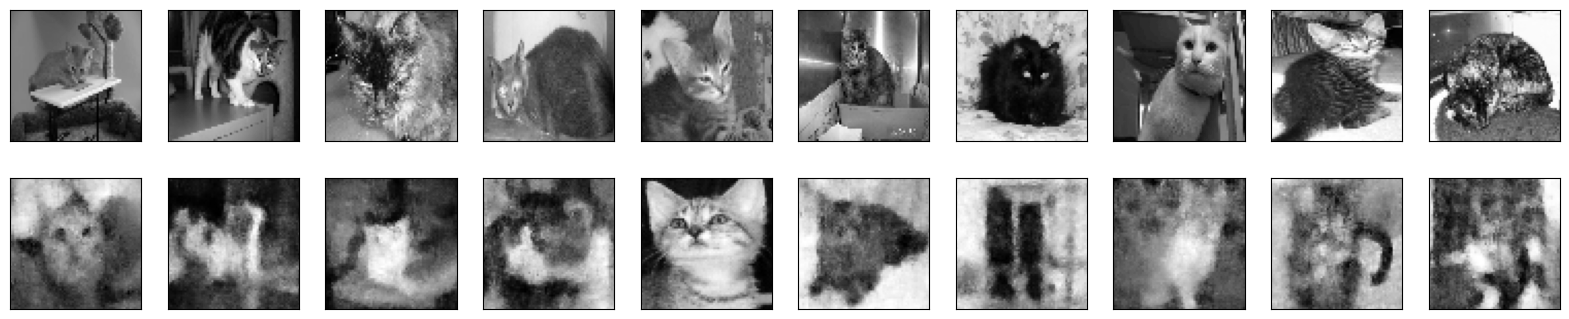

In [21]:
import matplotlib.pyplot as plt
decoded_imgs = vae.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for images, _ in x_train.take(1):
  for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].numpy().astype('float32'), cmap='gray')
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,1), cmap='gray')
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

1/1 [==============================] - 0s 18ms/step


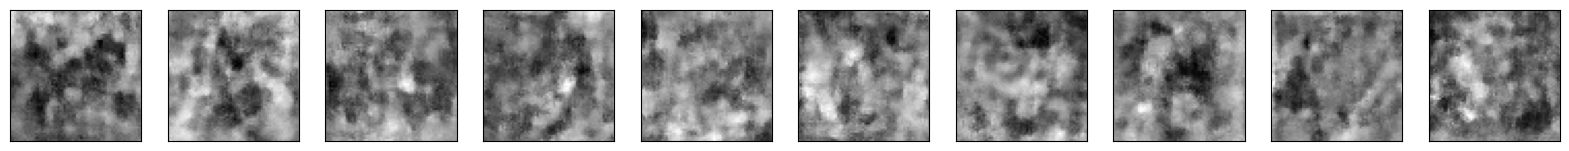

In [50]:
num_samples = 10
random_latent_vectors  = np.random.randn(10, 1024)#np.random.random((num_samples, img_size, img_size, 1))
decoded_imgs = decoder.predict(random_latent_vectors)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 )
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,1), cmap='gray')
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
vae.save('model.h5')

In [35]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 1024),               5372099   ['input_1[0][0]']             
                              (None, 1024),               20                                      
                              (None, 1024)]                                                       
                                                                                                  
 decoder (Functional)        (None, 64, 64, 1)            2688720   ['encoder[0][2]']             
                                                          65                                    

1/1 [==============================] - 0s 19ms/step


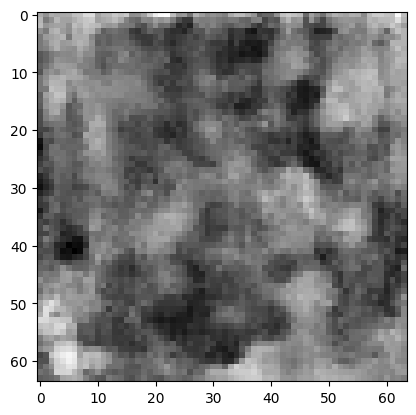

In [40]:
decoded_imgs = decoder.predict(np.random.randn(10, 1024))
plt.imshow(decoded_imgs[0].reshape(img_size, img_size,1), cmap='gray')